A car sharing company is developing a system that could assess the risk of an accident along a selected route. Risk is the probability of an accident with any damage to the vehicle. Once a driver has booked a car, got behind the wheel, and chosen a route, the system must assess the level of risk. If the risk level is high, the driver will see a warning and route recommendations.
The idea of creating such a system is at the stage of preliminary discussion and elaboration. There is no clear algorithm of work and similar solutions on the market yet. The current task is to understand whether it is possible to predict accidents based on the historical data of one of the regions.

**Formulation of the problem:**

Find the best model that will predict the driver's guilt in an accident. For the model, find the most important factors influencing the prediction. Based on the conclusions made, give recommendations on the need to equip the machine with additional sensors, a camera, etc.

**Project progress**:

- Statistical analysis
- Data preprocessing
- Creation of an accident prediction model
- Study of the main factors of road accidents
- Conclusions on key issues:
1. Is it possible to create an adequate driver risk assessment system when issuing a car?
2. What other factors need to be considered?
3. Is it necessary to equip the car with any sensors or camera?

**Project objective:**

Develop a model that will help predict the risk of a driver committing an accident along the route he has chosen.

##  Connection to the base. Loading sql tables

In [1]:
!pip3 install catboost
!pip3 install skorch
!pip3 install -U scikit-learn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import datetime
import matplotlib.pyplot as plt
import calendar
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import skorch
import catboost

from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV, cross_val_score, train_test_split
from skorch import NeuralNetClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sqlalchemy import create_engine 
from torch import optim
from catboost import CatBoostClassifier, cv, Pool, CatBoost
from catboost.utils import eval_metric, get_confusion_matrix
from sklearn.metrics import roc_curve, PrecisionRecallDisplay, recall_score, precision_score 
from sklearn.metrics import make_scorer, roc_auc_score, f1_score

sns.set(color_codes=True)

In [3]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-science-vehicle-db' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string) 

In [4]:
query = '''

SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_NAME IN ('vehicles', 'collisions', 'parties', 'case_ids')

'''

pd.read_sql_query(query, con=engine) 

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,data-science-vehicle-db,public,case_ids,BASE TABLE,None,None,None,None,None,YES,NO,None
1,data-science-vehicle-db,public,collisions,BASE TABLE,None,None,None,None,None,YES,NO,None
2,data-science-vehicle-db,public,parties,BASE TABLE,None,None,None,None,None,YES,NO,None
3,data-science-vehicle-db,public,vehicles,BASE TABLE,None,None,None,None,None,YES,NO,None


In [5]:
%%time
query = '''

SELECT *
FROM public.vehicles
WHERE case_id IN (SELECT case_id
                  FROM public.collisions
                  WHERE collision_damage NOT LIKE 'scratch' AND 
                        DATE_TRUNC('YEAR', collision_date)::DATE = '2012-01-01' AND
                        case_id IN (SELECT case_id
                                    FROM public.parties
                                    WHERE PARTY_TYPE LIKE 'car'))
'''

vehicles_df = pd.read_sql_query(query, con=engine) 
vehicles_df.count()

Wall time: 4.4 s


id                      62436
case_id                 62436
party_number            62436
vehicle_type            62436
vehicle_transmission    61389
vehicle_age             60677
dtype: int64

In [6]:
%%time
query = '''

SELECT *
FROM public.vehicles 
INNER JOIN (SELECT case_id
                  FROM public.collisions
                  WHERE collision_damage NOT LIKE 'scratch' AND 
                        DATE_TRUNC('YEAR', collision_date)::DATE = '2012-01-01' AND
                        case_id IN (SELECT case_id
                                    FROM public.parties
                                    WHERE PARTY_TYPE LIKE 'car')) AS c ON public.vehicles.case_id=c.case_id 
'''

pd.read_sql_query(query, con=engine).count()

Wall time: 3.55 s


id                      62436
case_id                 62436
party_number            62436
vehicle_type            62436
vehicle_transmission    61389
vehicle_age             60677
case_id                 62436
dtype: int64

In [7]:
%%time
query = '''

SELECT *
FROM public.parties
WHERE party_type LIKE 'car' AND
      case_id IN (SELECT case_id
                  FROM public.collisions
                  WHERE collision_damage NOT LIKE 'scratch' AND 
                        DATE_TRUNC('YEAR', collision_date)::DATE = '2012-01-01')
'''

parties_df = pd.read_sql_query(query, con=engine) 
parties_df.head()

Wall time: 7.53 s


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,2312523,5403037,1,car,1,19.0,"had been drinking, under influence",under drug influence,0.0
1,2395544,5448917,1,car,1,43.0,had not been drinking,None,0.0
2,2313227,5403431,1,car,1,43.0,"had been drinking, under influence",None,NaN
3,2313317,5403481,2,car,0,38.0,had not been drinking,None,0.0
4,2313460,5403569,1,car,0,44.0,had not been drinking,None,0.0


In [8]:
%%time
query = '''

SELECT *
FROM public.collisions
WHERE collision_damage NOT LIKE 'scratch' AND 
      DATE_TRUNC('YEAR', collision_date)::DATE = '2012-01-01' AND
      case_id IN (SELECT case_id
                  FROM public.parties
                  WHERE PARTY_TYPE LIKE 'car')     
'''

collisions_df = pd.read_sql_query(query, con=engine) 
collisions_df.head()

Wall time: 11.6 s


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,5403318,2002,madera,30.0,west,0.0,None,None,fatal,3,vehicle code violation,automobile right of way,broadside,other motor vehicle,None,normal,daylight,none,2012-01-29,12:00:00
1,5403449,1301,imperial,131.0,west,0.0,clear,highway,fatal,1,vehicle code violation,wrong side of road,hit object,fixed object,dry,normal,daylight,functioning,2012-02-03,09:41:00
2,5454375,3607,san bernardino,1694.0,west,0.0,clear,highway,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2012-01-30,16:25:00
3,5456673,2701,monterey,44.0,north,0.0,clear,None,small damage,2,vehicle code violation,unsafe starting or backing,rear end,other motor vehicle,dry,normal,daylight,none,2012-01-11,14:02:00
4,5456677,3607,san bernardino,400.0,east,0.0,clear,highway,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,none,2012-01-14,20:33:00


## Primary examination of tables

Function to quickly view unique string values in a table:

In [9]:
def cat_unique(i):
    for column in i:
        if i[column].dtype=='object':
            print({i[column].name : i[column].sort_values().unique()})
            print('_' * 100)

Function to visualize the distribution of numerical data:

In [10]:
def data_distribution(tab):
    for column in tab:
        if tab[column].dtype == 'int64' or tab[column].dtype == 'float64': 
            display(_=sns.catplot(y=column, kind='violin', data=tab))  

Function to visualize information about the number of missing values:

In [11]:
def isna_style(x):
    mis_val = x.isnull().sum()
    mis_val_percent = (100 * x.isnull().sum() / len(x)).round(1)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'count_nan', 1 : '%_nan'})
    return mis_val_table_ren_columns.style.background_gradient('cool')

In [12]:
list_df = [vehicles_df, parties_df, collisions_df]
for i in list_df:
    display(isna_style(i))

,count_nan,%_nan
id,0,0.000000
case_id,0,0.000000
party_number,0,0.000000
vehicle_type,0,0.000000
vehicle_transmission,1047,1.700000
vehicle_age,1759,2.800000


,count_nan,%_nan
id,0,0.000000
case_id,0,0.000000
party_number,0,0.000000
party_type,0,0.000000
at_fault,0,0.000000
insurance_premium,20230,10.300000
party_sobriety,3625,1.800000
party_drug_physical,171689,87.200000
cellphone_in_use,25373,12.900000


,count_nan,%_nan
case_id,0,0.000000
county_city_location,0,0.000000
county_location,0,0.000000
distance,0,0.000000
direction,23896,20.800000
intersection,698,0.600000
weather_1,414,0.400000
location_type,68575,59.800000
collision_damage,0,0.000000
party_count,0,0.000000


In [13]:
list_df = [vehicles_df, parties_df, collisions_df]
for i in list_df:
    print(i.info())
    print(i.describe(include='all'))
    print(i.duplicated().value_counts())
    print(cat_unique(i))
    
    print('🦔🐇🐶'*15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62436 entries, 0 to 62435
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    62436 non-null  int64  
 1   case_id               62436 non-null  object 
 2   party_number          62436 non-null  int64  
 3   vehicle_type          62436 non-null  object 
 4   vehicle_transmission  61389 non-null  object 
 5   vehicle_age           60677 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 2.9+ MB
None
                  id  case_id  party_number vehicle_type vehicle_transmission  \
count   6.243600e+04    62436  62436.000000        62436                61389   
unique           NaN    49542           NaN            5                    2   
top              NaN  5542351           NaN        sedan               manual   
freq             NaN        8           NaN        37839                33516   
mean    1.42

False    114727
dtype: int64
{'case_id': array(['5064690', '5125160', '5125192', ..., '5668367', '5668368',
       '5668369'], dtype=object)}
____________________________________________________________________________________________________
{'county_city_location': array(['0100', '0101', '0102', '0103', '0104', '0105', '0106', '0107',
       '0108', '0109', '0110', '0111', '0112', '0113', '0198', '0200',
       '0300', '0302', '0303', '0305', '0400', '0401', '0402', '0403',
       '0404', '0405', '0500', '0501', '0600', '0601', '0602', '0700',
       '0701', '0702', '0703', '0704', '0705', '0706', '0707', '0708',
       '0709', '0710', '0711', '0712', '0713', '0714', '0715', '0716',
       '0734', '0790', '0791', '0792', '0800', '0801', '0900', '0901',
       '0902', '1000', '1001', '1002', '1003', '1004', '1005', '1007',
       '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015',
       '1100', '1101', '1102', '1200', '1201', '1203', '1205', '1300',
       '1301', '1302',

____________________________________________________________________________________________________
{'control_device': array(['functioning', 'none', 'not functioning', 'obscured', None],
      dtype=object)}
____________________________________________________________________________________________________
{'collision_date': array([datetime.date(2012, 1, 1), datetime.date(2012, 1, 2),
       datetime.date(2012, 1, 3), datetime.date(2012, 1, 4),
       datetime.date(2012, 1, 5), datetime.date(2012, 1, 6),
       datetime.date(2012, 1, 7), datetime.date(2012, 1, 8),
       datetime.date(2012, 1, 9), datetime.date(2012, 1, 10),
       datetime.date(2012, 1, 11), datetime.date(2012, 1, 12),
       datetime.date(2012, 1, 13), datetime.date(2012, 1, 14),
       datetime.date(2012, 1, 15), datetime.date(2012, 1, 16),
       datetime.date(2012, 1, 17), datetime.date(2012, 1, 18),
       datetime.date(2012, 1, 19), datetime.date(2012, 1, 20),
       datetime.date(2012, 1, 21), datetime.date(2

{'collision_time': array([datetime.time(0, 0), datetime.time(0, 1), datetime.time(0, 2), ...,
       datetime.time(23, 58), datetime.time(23, 59), None], dtype=object)}
____________________________________________________________________________________________________
None
🦔🐇🐶🦔🐇🐶🦔🐇🐶🦔🐇🐶🦔🐇🐶🦔🐇🐶🦔🐇🐶🦔🐇🐶🦔🐇🐶🦔🐇🐶🦔🐇🐶🦔🐇🐶🦔🐇🐶🦔🐇🐶🦔🐇🐶


There are gaps in the data. They must be filled in for the model to work correctly in the future.

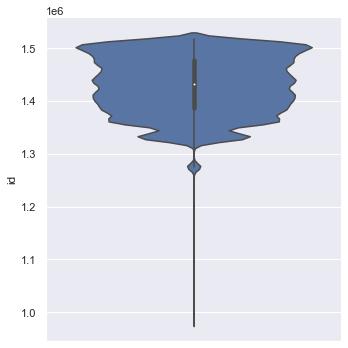

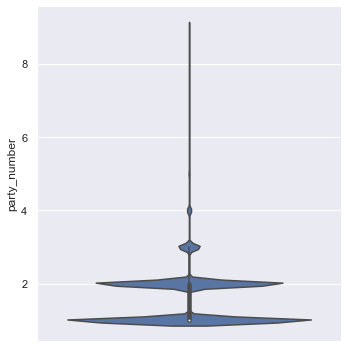

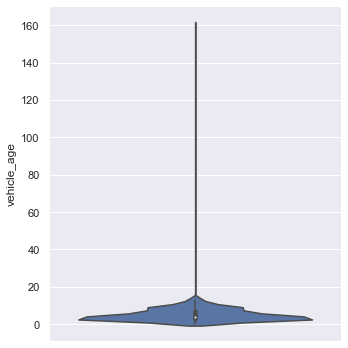

In [14]:
data_distribution(vehicles_df)

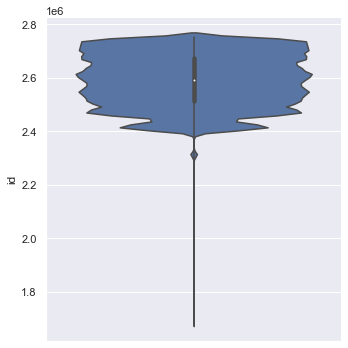

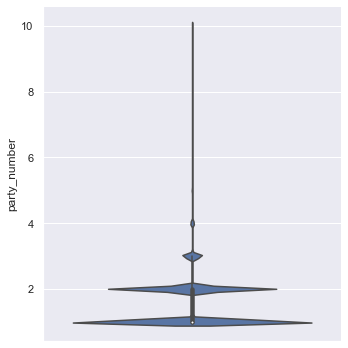

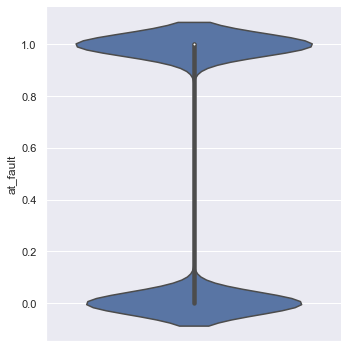

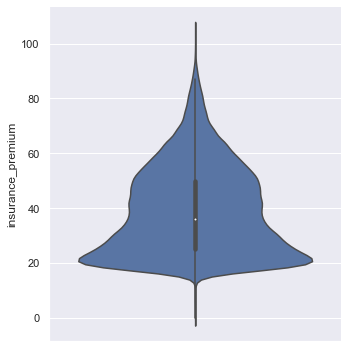

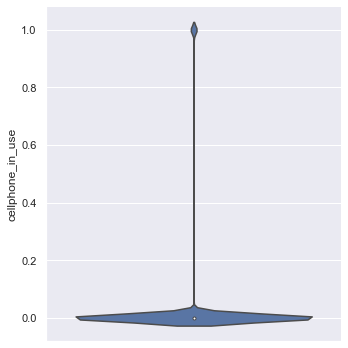

In [15]:
data_distribution(parties_df)

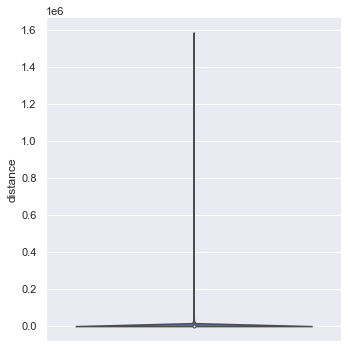

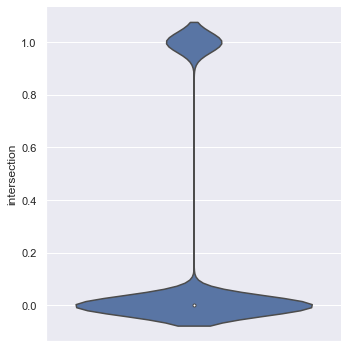

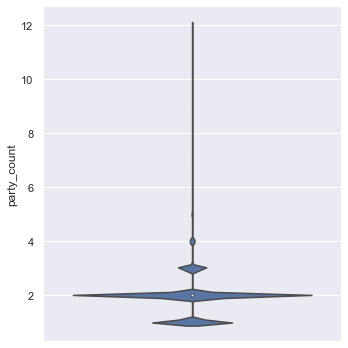

In [16]:
data_distribution(collisions_df)

In the vehicles_df table (damaged vehicles), there are about 3% gaps. They can be removed.

In [17]:
vehicles_df = vehicles_df.dropna()

Converting the `case_id` field to a numeric format for further joining tables on it

In [18]:
list_df = [vehicles_df, parties_df, collisions_df]
for i in list_df:
    i['case_id'] = i['case_id'].map(int)

Merging tables by `case_id`

In [19]:
%%time
parties_vehicles_df = parties_df.merge(vehicles_df, on='case_id', how='inner')
data_df = parties_vehicles_df.merge(collisions_df, on='case_id', how='inner')

Wall time: 357 ms


In [20]:
%%time
query = '''

WITH 
vehicles AS (SELECT *
            FROM public.vehicles
            WHERE case_id IN (SELECT case_id
                              FROM public.collisions
                              WHERE collision_damage NOT LIKE 'scratch' AND 
                                    DATE_TRUNC('YEAR', collision_date)::DATE = '2012-01-01' AND
                                    case_id IN (SELECT case_id
                                                FROM public.parties
                                                WHERE PARTY_TYPE LIKE 'car'))
                             ),

parties AS (SELECT *
            FROM public.parties
            WHERE party_type LIKE 'car' AND
                  case_id IN (SELECT case_id
                       FROM public.collisions
                       WHERE collision_damage NOT LIKE 'scratch' AND 
                             DATE_TRUNC('YEAR', collision_date)::DATE = '2012-01-01')
                             ),

collisions AS (SELECT *
               FROM public.collisions
               WHERE collision_damage NOT LIKE 'scratch' AND 
                     DATE_TRUNC('YEAR', collision_date)::DATE = '2012-01-01' AND
                     case_id IN (SELECT case_id
                                 FROM public.parties
                                 WHERE PARTY_TYPE LIKE 'car')
                                 )  

SELECT *
FROM vehicles
INNER JOIN parties ON vehicles.case_id=parties.case_id
INNER JOIN collisions ON vehicles.case_id=collisions.case_id

'''

pd.read_sql_query(query, con=engine).head(5)


Wall time: 21.9 s


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age,id,case_id,party_number,party_type,...,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,985527,5125160,2,sedan,auto,2.0,1800807,5125160,2,car,...,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,other,daylight,none,2012-03-30,07:40:00
1,985527,5125160,2,sedan,auto,2.0,1800806,5125160,1,car,...,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,other,daylight,none,2012-03-30,07:40:00
2,1034905,5173738,2,sedan,auto,5.0,1891423,5173738,1,car,...,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2012-04-02,12:54:00
3,1034905,5173738,2,sedan,auto,5.0,1891424,5173738,2,car,...,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2012-04-02,12:54:00
4,1137350,5269486,2,sedan,auto,1.0,2066627,5269486,2,car,...,unknown,unknown,broadside,other motor vehicle,dry,normal,daylight,functioning,2012-11-13,16:35:00


Separate the month from the `collision_date` field for the convenience of statistical data analysis in the future.

In [21]:
data_df.collision_date = pd.to_datetime(data_df.collision_date).dt.month

##  Statistical analysis of accident factors

### Accident analysis over time

 #### Analysis of the number of car accidents by months in 2011

In [22]:
%%time
query = '''

SELECT *
FROM public.collisions
WHERE collision_damage NOT IN ('scratch') AND 
      DATE_TRUNC('YEAR', collision_date)::DATE = '2011-01-01' AND
      case_id IN (SELECT case_id
                  FROM public.parties
                  WHERE PARTY_TYPE LIKE 'car')     
'''

collisions_2011_df = pd.read_sql_query(query, con=engine) 

Wall time: 27.3 s


In [23]:
collisions_2011_df.collision_date = pd.to_datetime(collisions_2011_df.collision_date).dt.month

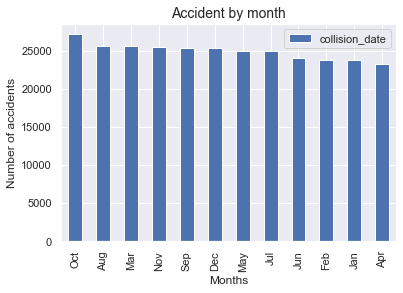

In [24]:
pd.DataFrame(collisions_2011_df['collision_date'].apply(lambda x: calendar.month_abbr[x]).value_counts()).plot(
    kind='bar').set_title('Accident by month', fontsize=14)

plt.xlabel('Months', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

#### Analysis of the number of car accidents by months for the entire sample

In [25]:
%%time
query = '''

SELECT *
FROM public.collisions
WHERE collision_damage NOT IN ('scratch') AND
      case_id IN (SELECT case_id
                  FROM public.parties
                  WHERE PARTY_TYPE LIKE 'car')     
'''

whole_collisions_df = pd.read_sql_query(query, con=engine) 

Wall time: 1min 40s


In [26]:
whole_collisions_df['collision_month'] = pd.to_datetime(whole_collisions_df.collision_date).dt.month

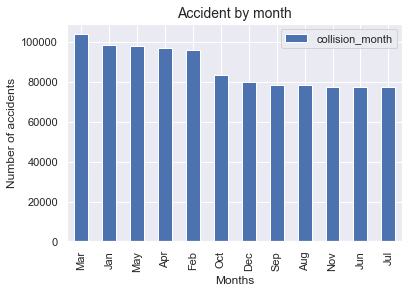

In [27]:
pd.DataFrame(whole_collisions_df['collision_month'].apply(lambda x: calendar.month_abbr[x]).value_counts()).plot(
    kind='bar').set_title('Accident by month', fontsize=14)

plt.xlabel('Months', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

In [28]:
whole_collisions_df['collision_year'] = pd.to_datetime(whole_collisions_df.collision_date).dt.year

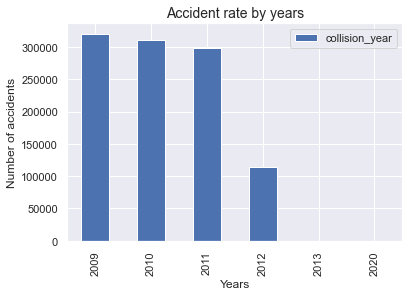

In [29]:
pd.DataFrame(whole_collisions_df['collision_year'].value_counts()).plot(
    kind='bar').set_title('Accident rate by years', fontsize=14)

plt.xlabel('Years', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

#### Analysis of the number of car accidents by months in 2012

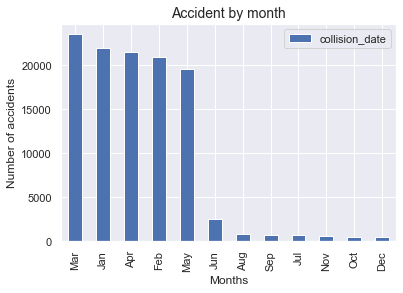

In [30]:
pd.DataFrame(data_df['collision_date'].apply(lambda x: calendar.month_abbr[x]).value_counts()).plot(
    kind='bar').set_title('Accident by month', fontsize=14)

plt.xlabel('Months', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

**Conclusion:** The accident rate as a whole decreases over the years, but in 2012 there is a sharp decrease in the accident rate in the second half of the year. Perhaps in 2012 they stopped collecting data in some locations.

### Vehicle damage severity analysis

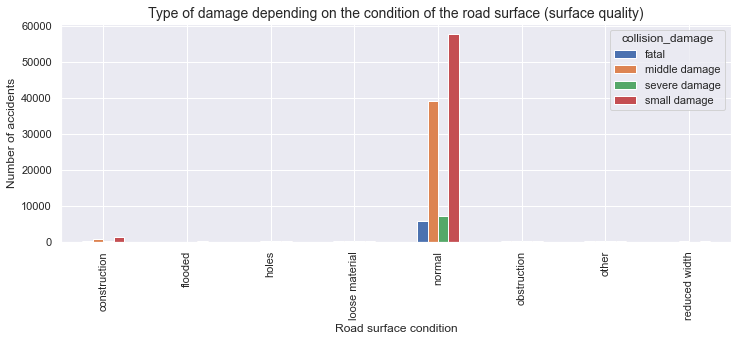

In [31]:
data_df.pivot_table(index='road_condition_1', columns='collision_damage', values='at_fault', aggfunc='count').plot(
    kind='bar', figsize=(12, 4)).set_title('Type of damage depending on the condition of the road surface (surface quality)', fontsize=14)

plt.xlabel('Road surface condition', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

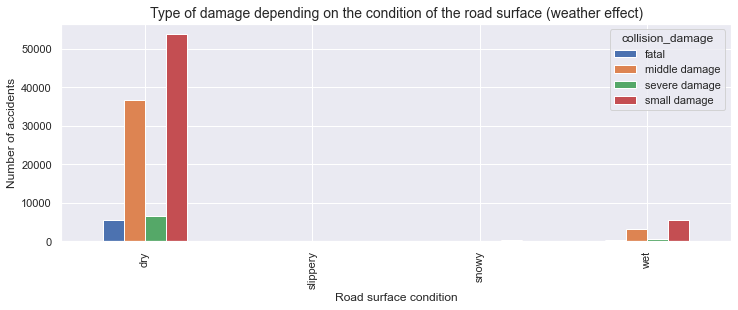

In [32]:
data_df.pivot_table(index='road_surface', columns='collision_damage', values='at_fault', aggfunc='count').plot(
    kind='bar', figsize=(12, 4)).set_title('Type of damage depending on the condition of the road surface (weather effect)', fontsize=14)

plt.xlabel('Road surface condition', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

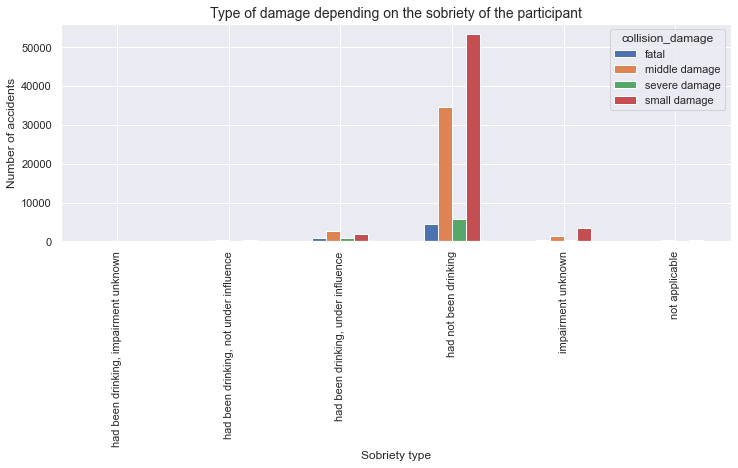

In [33]:
data_df.pivot_table(index='party_sobriety', columns='collision_damage', values='at_fault', aggfunc='count').plot(
    kind='bar', figsize=(12, 4)).set_title('Type of damage depending on the sobriety of the participant', fontsize=14)

plt.xlabel('Sobriety type', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

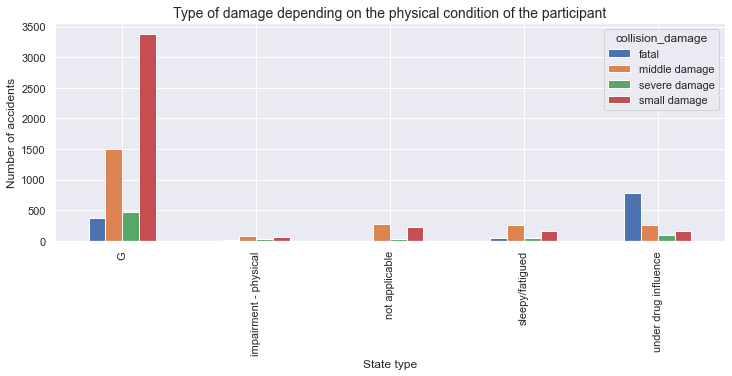

In [34]:
data_df.pivot_table(index='party_drug_physical', columns='collision_damage', values='at_fault', aggfunc='count').plot(
    kind='bar', figsize=(12, 4)).set_title('Type of damage depending on the physical condition of the participant', fontsize=14)

plt.xlabel('State type', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

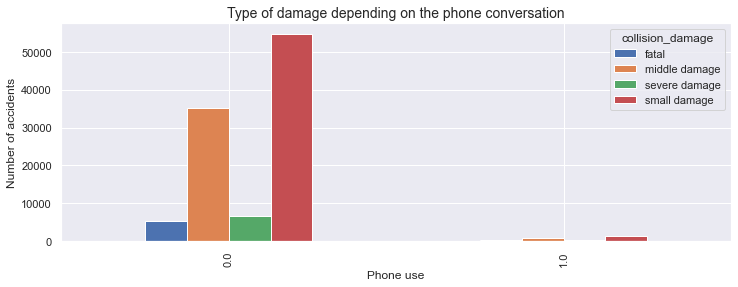

In [35]:
data_df.pivot_table(index='cellphone_in_use', columns='collision_damage', values='at_fault', aggfunc='count').plot(
    kind='bar', figsize=(12, 4)).set_title('Type of damage depending on the phone conversation', fontsize=14)

plt.xlabel('Phone use', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

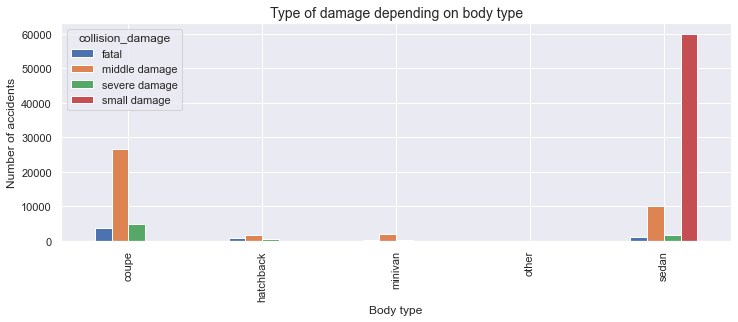

In [36]:
data_df.pivot_table(index='vehicle_type', columns='collision_damage', values='at_fault', aggfunc='count').plot(
    kind='bar', figsize=(12, 4)).set_title('Type of damage depending on body type', fontsize=14)

plt.xlabel('Body type', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

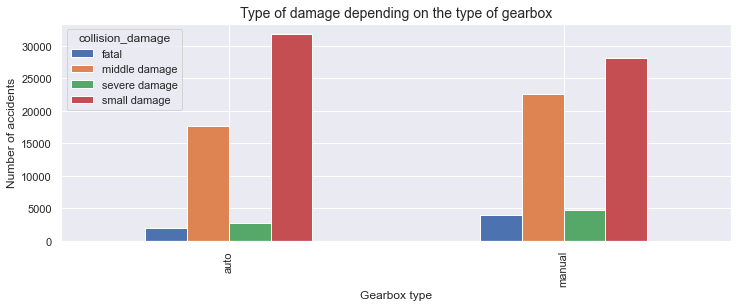

In [37]:
data_df.pivot_table(index='vehicle_transmission', columns='collision_damage', values='at_fault', aggfunc='count').plot(
    kind='bar', figsize=(12, 4)).set_title('Type of damage depending on the type of gearbox', fontsize=14)

plt.xlabel('Gearbox type', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

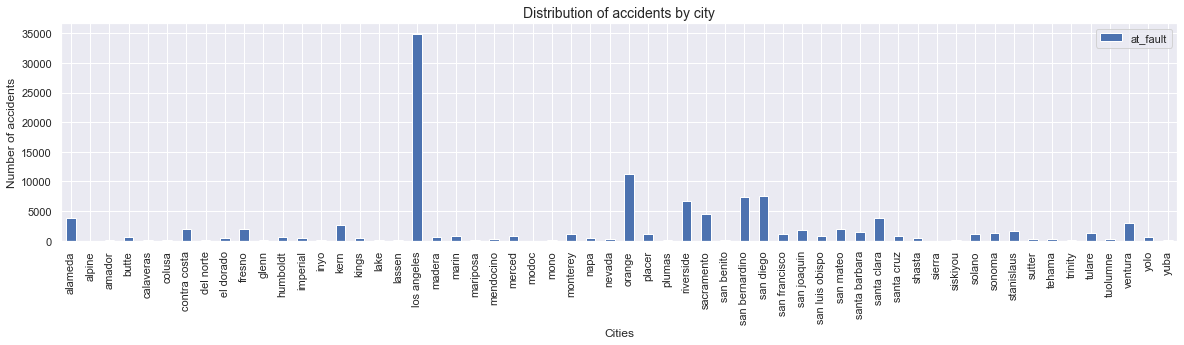

In [38]:
data_df.pivot_table(index='county_location', values='at_fault', aggfunc='count').plot(
    kind='bar', figsize=(20, 4)).set_title('Distribution of accidents by city', fontsize=14)

plt.xlabel('Cities', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

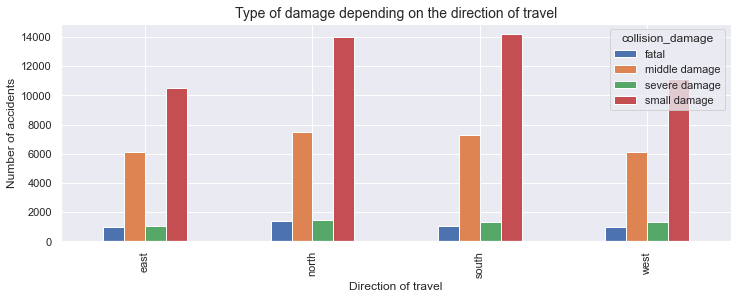

In [39]:
data_df.pivot_table(index='direction', columns='collision_damage', values='at_fault', aggfunc='count').plot(
    kind='bar', figsize=(12, 4)).set_title('Type of damage depending on the direction of travel', fontsize=14)

plt.xlabel('Direction of travel', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

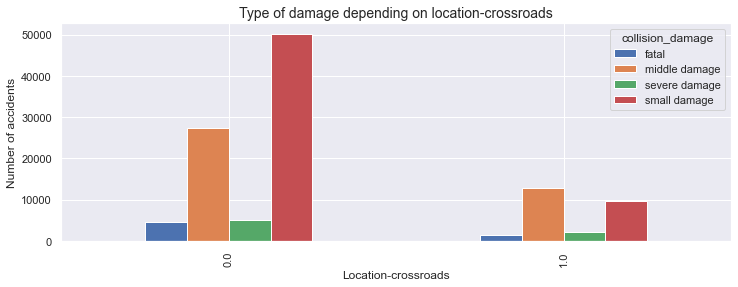

In [40]:
data_df.pivot_table(index='intersection', columns='collision_damage', values='at_fault', aggfunc='count').plot(
    kind='bar', figsize=(12, 4)).set_title('Type of damage depending on location-crossroads', fontsize=14)

plt.xlabel('Location-crossroads', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

The `intersection` field duplicates the information in the road type (`location_type`) field. Therefore, it can be removed.

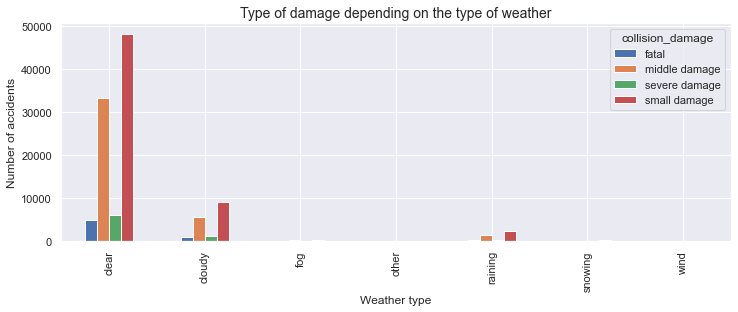

In [41]:
data_df.pivot_table(index='weather_1', columns='collision_damage', values='at_fault', aggfunc='count').plot(
    kind='bar', figsize=(12, 4)).set_title('Type of damage depending on the type of weather', fontsize=14)

plt.xlabel('Weather type', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

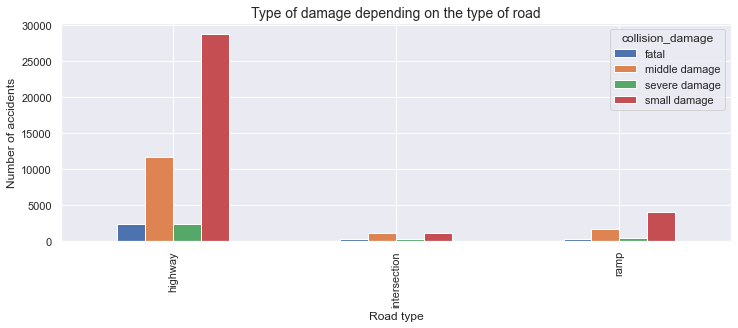

In [42]:
data_df.pivot_table(index='location_type', columns='collision_damage', values='at_fault', aggfunc='count').plot(
    kind='bar', figsize=(12, 4)).set_title('Type of damage depending on the type of road', fontsize=14)

plt.xlabel('Road type', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

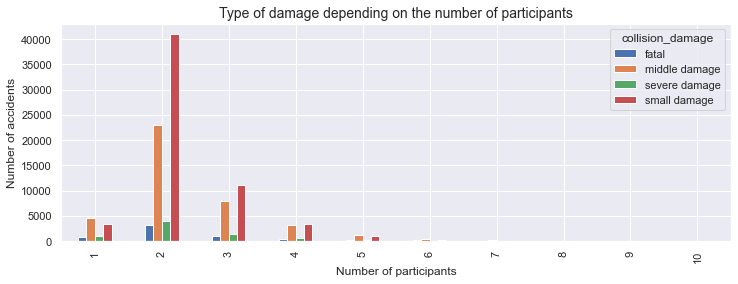

In [43]:
data_df.pivot_table(index='party_count', columns='collision_damage', values='at_fault', aggfunc='count').plot(
    kind='bar', figsize=(12, 4)).set_title('Type of damage depending on the number of participants', fontsize=14)

plt.xlabel('Number of participants', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

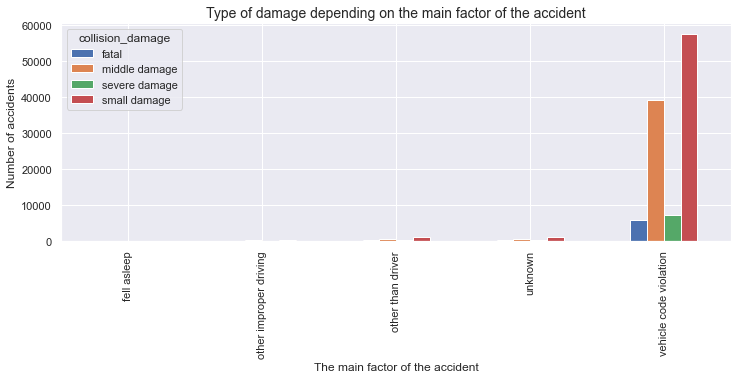

In [44]:
data_df.pivot_table(index='primary_collision_factor', columns='collision_damage', values='at_fault', aggfunc='count').plot(
    kind='bar', figsize=(12, 4)).set_title('Type of damage depending on the main factor of the accident', fontsize=14)

plt.xlabel('The main factor of the accident', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

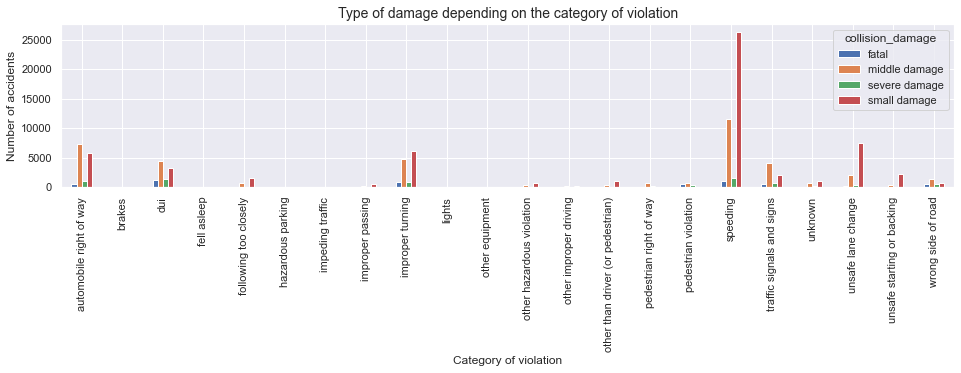

In [45]:
data_df.pivot_table(index='pcf_violation_category', columns='collision_damage', values='at_fault', aggfunc='count').plot(
    kind='bar', figsize=(16, 3)).set_title('Type of damage depending on the category of violation', fontsize=14)

plt.xlabel('Category of violation', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

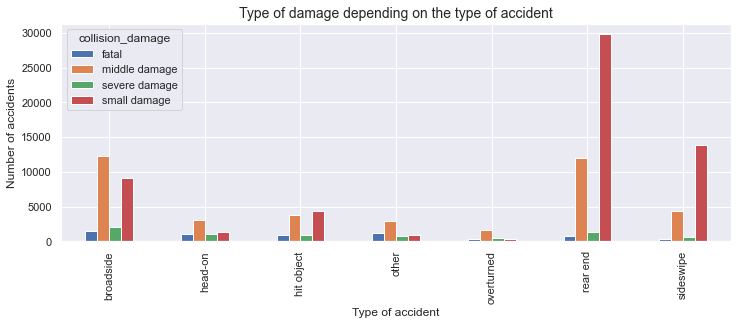

In [46]:
data_df.pivot_table(index='type_of_collision', columns='collision_damage', values='at_fault', aggfunc='count').plot(
    kind='bar', figsize=(12, 4)).set_title('Type of damage depending on the type of accident', fontsize=14)

plt.xlabel('Type of accident', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

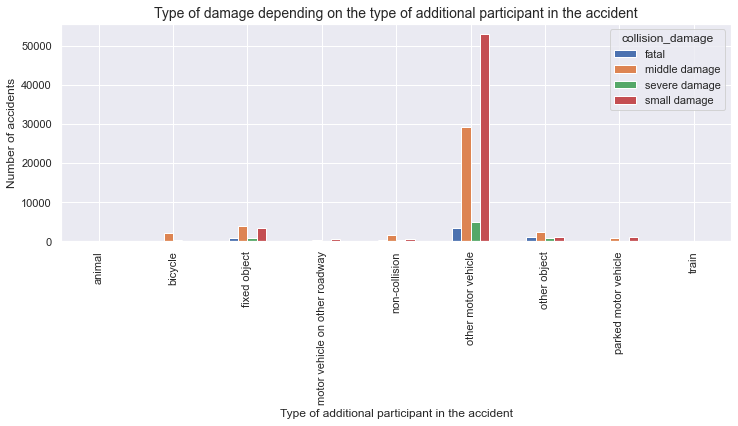

In [47]:
data_df.pivot_table(index='motor_vehicle_involved_with', columns='collision_damage', values='at_fault', aggfunc='count').plot(
    kind='bar', figsize=(12, 4)).set_title('Type of damage depending on the type of additional participant in the accident', fontsize=14)

plt.xlabel('Type of additional participant in the accident', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

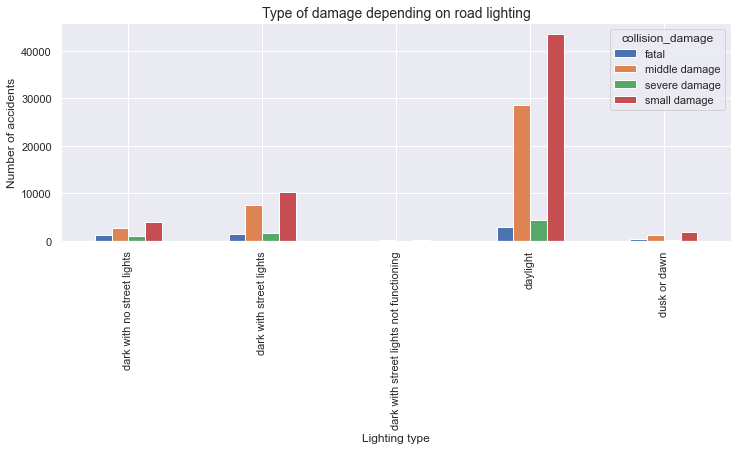

In [48]:
data_df.pivot_table(index='lighting', columns='collision_damage', values='at_fault', aggfunc='count').plot(
    kind='bar', figsize=(12, 4)).set_title('Type of damage depending on road lighting', fontsize=14)

plt.xlabel('Lighting type', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

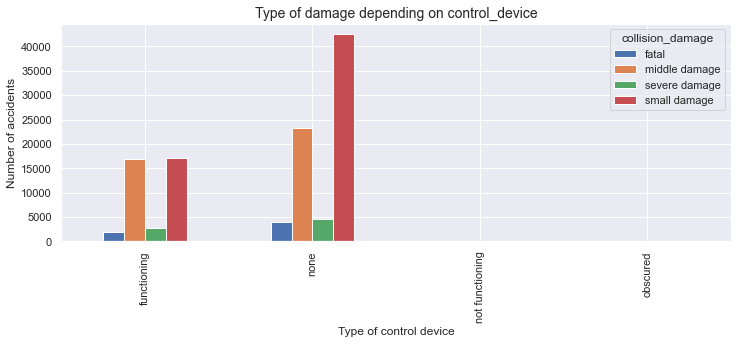

In [49]:
data_df.pivot_table(index='control_device', columns='collision_damage', values='at_fault', aggfunc='count').plot(
    kind='bar', figsize=(12, 4)).set_title('Type of damage depending on control_device', fontsize=14)

plt.xlabel('Type of control device', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

**Conclusion:**

In each of the above graphs, in the leading category in terms of the number of cases, the absolute leader is the mild degree of damage, the second is the average. Serious with fatal in the last positions. In other categories, the distribution of damage may be different. At this stage, the graphs were displayed to track the statistics of the data in order to further process them.

#### Tasks for employees

1. Conduct an analysis of the main factor of the accident depending on the severity of the accident
2. Analyze the main factor of the accident from the age of the car
3. Conduct an analysis of the main factor of the accident from the category of violation
4. Find out if there is a dependence of the driver’s guilt in an accident on his physical condition (alcohol intoxication, drug intoxication, overwork, etc.)
5. Find out if there is a dependence of the physical condition of the driver on the time of the accident
6. Does the type of lighting affect the culpability in an accident

Solution order for 4 points:

1. Write SQL query
2. Construct graphs of the dependence of the physical state on the guilt of the driver (check all the signs related to the physical state of the driver: `PARTY_DRUG_PHYSICAL, PARTY_SOBRIETY, PCF_VIOLATION_CATEGORY, PRIMARY_COLL_FACTOR`). There should be multiple charts. Graphs must be bar charts. The y-axis should show the number of accidents.
3. For each graph, give a conclusion. At the end, give a final conclusion.

Solution order for 5 points:

1. Write SQL query
2. Construct graphs of the dependence of the physical state of the driver on the time of the accident (check all the features related to the physical state of the driver: `PARTY_DRUG_PHYSICAL, PARTY_SOBRIETY, PCF_VIOLATION_CATEGORY, PRIMARY_COLL_FACTOR`). There should be multiple charts. Graphs must be bar charts. The y-axis should show the number of accidents.
3. For each graph, give a conclusion. At the end, give a final conclusion.

## Data preprocessing

**Cleaning data from anomalies**

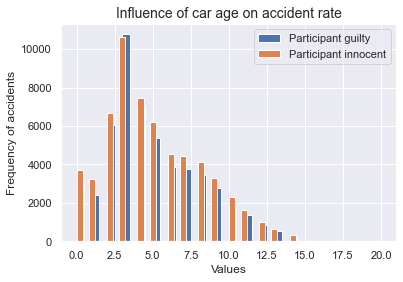

In [50]:
data_df[data_df['at_fault']==1].vehicle_age.hist(bins=40, range=(0, 20));
data_df[data_df['at_fault']==0].vehicle_age.hist(bins=50, range=(0, 20)).set_title('Influence of car age on accident rate', fontsize=14)
plt.legend(['Participant guilty', 'Participant innocent'])
plt.xlabel('Values', fontsize=12)
plt.ylabel('Frequency of accidents', fontsize=12);

In [51]:
data_df_ = data_df.loc[data_df['vehicle_age'] < 20]

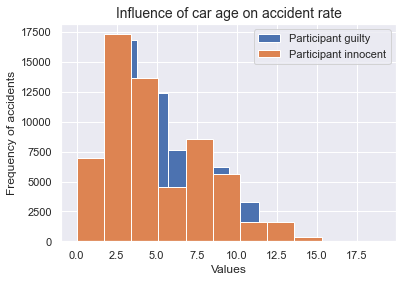

In [52]:
data_df_[data_df_['at_fault']==1].vehicle_age.hist();
data_df_[data_df_['at_fault']==0].vehicle_age.hist().set_title('Influence of car age on accident rate', fontsize=14)
plt.legend(['Participant guilty', 'Participant innocent'])
plt.xlabel('Values', fontsize=12)
plt.ylabel('Frequency of accidents', fontsize=12);

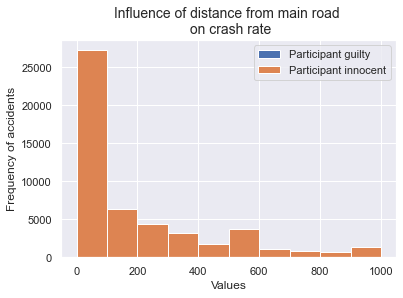

In [53]:
data_df_[data_df_['at_fault']==1].distance.hist(bins=10, range=(0, 1000));
data_df_[data_df_['at_fault']==0].distance.hist(bins=10, range=(0, 1000)).set_title('Influence of distance from main road \n on crash rate', fontsize=14)
plt.legend(['Participant guilty', 'Participant innocent'])
plt.xlabel('Values', fontsize=12)
plt.ylabel('Frequency of accidents', fontsize=12);

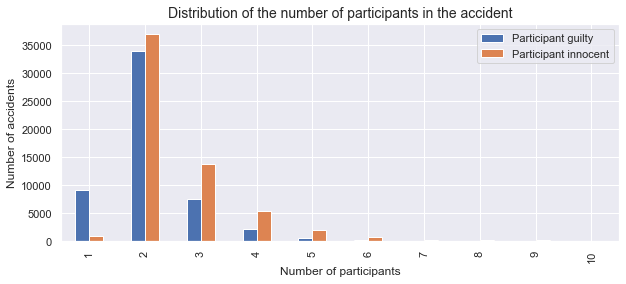

In [54]:
weather_fault_1 = data_df_[data_df_['at_fault']==1].pivot_table(index='party_count', values='at_fault', aggfunc='count')
weather_fault_0 = data_df_[data_df_['at_fault']==0].pivot_table(index='party_count', values='at_fault', aggfunc='count')
weather_fault_1.merge(weather_fault_0, on='party_count', how='outer').plot(kind='bar', figsize=(10, 4)).set_title('Distribution of the number of participants in the accident', fontsize=14)
plt.legend(['Participant guilty', 'Participant innocent'])
plt.xlabel('Number of participants', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

**In the alcohol intoxication (`party_sobriety`) column, there are about 1% gaps, so they can be removed**

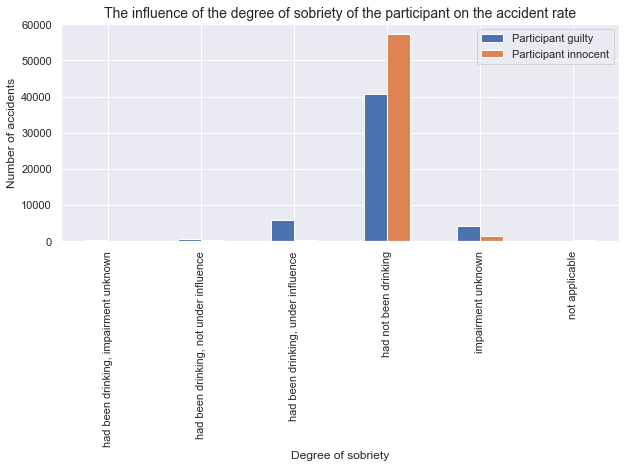

In [55]:
df_1 = data_df_[data_df_['at_fault']==1].pivot_table(index='party_sobriety', values='at_fault', aggfunc='count')
df_0 = data_df_[data_df_['at_fault']==0].pivot_table(index='party_sobriety', values='at_fault', aggfunc='count')
df_1.merge(df_0, on='party_sobriety', how='outer').plot(kind='bar', figsize=(10, 4)).set_title('The influence of the degree of sobriety of the participant on the accident rate', fontsize=14)
plt.legend(['Participant guilty', 'Participant innocent'])
plt.xlabel('Degree of sobriety', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

In [56]:
data_df_ = data_df_.dropna(subset=['party_sobriety'])
data_df_[data_df_.party_sobriety.isna() == True]

,id_x,case_id,party_number_x,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,id_y,...,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time


**Fill in the blanks in the cell phone use field (`cellphone_in_use`)**

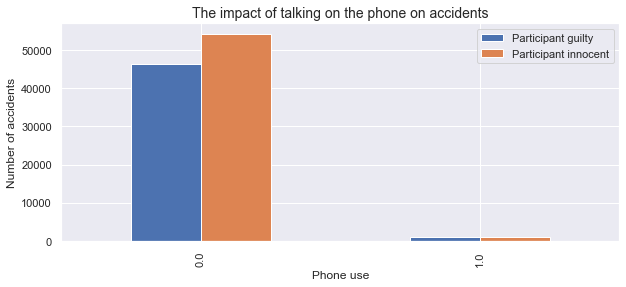

In [57]:
df_1 = data_df_[data_df_['at_fault']==1].pivot_table(index='cellphone_in_use', values='at_fault', aggfunc='count')
df_0 = data_df_[data_df_['at_fault']==0].pivot_table(index='cellphone_in_use', values='at_fault', aggfunc='count')
df_1.merge(df_0, on='cellphone_in_use', how='outer').plot(kind='bar', figsize=(10, 4)).set_title('The impact of talking on the phone on accidents', fontsize=14)
plt.legend(['Participant guilty', 'Participant innocent'])
plt.xlabel('Phone use', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

In [58]:
data_df_.loc[(data_df_.loc[:,'party_sobriety'] == ('had been drinking, under influence' or 
                                                   'had been drinking, impairment unknown' or
                                                   'not applicable')) & 
             (data_df_.loc[:,'cellphone_in_use'].isna() == True), 'cellphone_in_use'] = 0
              
data_df_.loc[(data_df_.loc[:,'party_sobriety'] == ('had not been drinking' or 
                                                   'impairment unknown' or 
                                                   'had been drinking, not under influence')) & 
             (data_df_.loc[:,'cellphone_in_use'].isna() == True), 'cellphone_in_use'] = 1

In [59]:
data_df_ = data_df_.dropna(subset=['cellphone_in_use'])
data_df_[data_df_.party_sobriety.isna() == True]

,id_x,case_id,party_number_x,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,id_y,...,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time


In [60]:
data_df_['cellphone_in_use'] = data_df_['cellphone_in_use'].map(int)

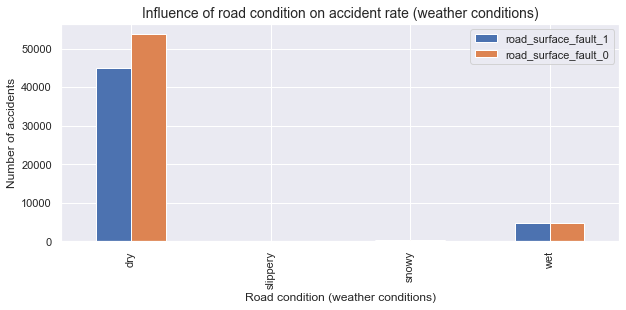

In [61]:
road_surface_fault_1 = data_df_[data_df_['at_fault']==1].pivot_table(index='road_surface', values='at_fault', aggfunc='count')
road_surface_fault_0 = data_df_[data_df_['at_fault']==0].pivot_table(index='road_surface', values='at_fault', aggfunc='count')
road_surface_fault_1.merge(road_surface_fault_0, on='road_surface', how='outer').plot(kind='bar', figsize=(10, 4)).set_title('Influence of road condition on accident rate (weather conditions)', fontsize=14)
plt.legend(['road_surface_fault_1', 'road_surface_fault_0'])
plt.xlabel('Road condition (weather conditions)', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

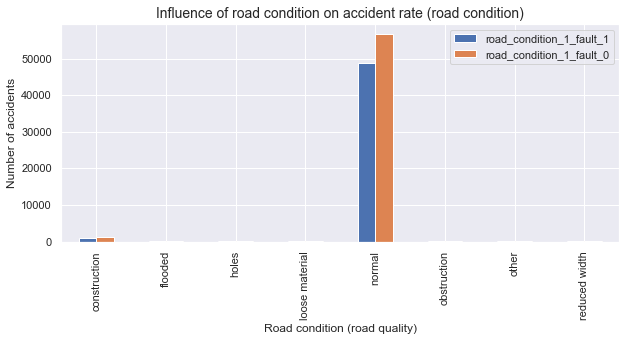

In [62]:
road_condition_1_fault_1 = data_df_[data_df_['at_fault']==1].pivot_table(index='road_condition_1', values='at_fault', aggfunc='count')
road_condition_1_fault_0 = data_df_[data_df_['at_fault']==0].pivot_table(index='road_condition_1', values='at_fault', aggfunc='count')
road_condition_1_fault_1.merge(road_condition_1_fault_0, on='road_condition_1', how='outer').plot(kind='bar', figsize=(10, 4)).set_title(
      'Influence of road condition on accident rate (road condition)', fontsize=14)
plt.legend(['road_condition_1_fault_1', 'road_condition_1_fault_0'])
plt.xlabel('Road condition (road quality)', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

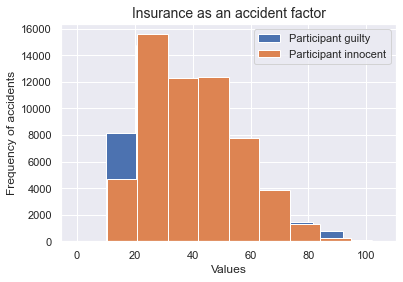

In [63]:
data_df_[data_df_['at_fault']==1].insurance_premium.hist();
data_df_[data_df_['at_fault']==0].insurance_premium.hist().set_title('Insurance as an accident factor', fontsize=14)
plt.legend(['Participant guilty', 'Participant innocent'])
plt.xlabel('Values', fontsize=12)
plt.ylabel('Frequency of accidents', fontsize=12);

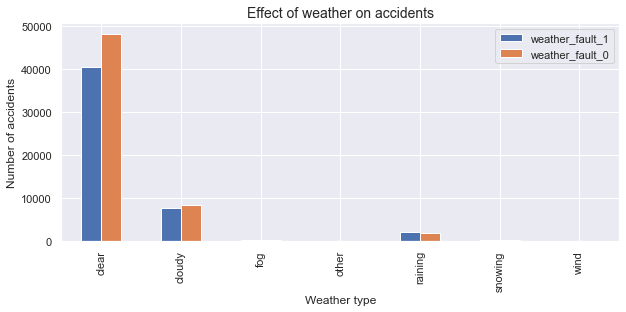

In [64]:
weather_fault_1 = data_df_[data_df_['at_fault']==1].pivot_table(index='weather_1', values='at_fault', aggfunc='count')
weather_fault_0 = data_df_[data_df_['at_fault']==0].pivot_table(index='weather_1', values='at_fault', aggfunc='count')
weather_fault_1.merge(weather_fault_0, on='weather_1', how='outer').plot(kind='bar', figsize=(10, 4)).set_title('Effect of weather on accidents', fontsize=14)
plt.legend(['weather_fault_1', 'weather_fault_0'])
plt.xlabel('Weather type', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

The most frequent weather by month:

In [65]:
for i in range(1, 13):
    print(data_df_.loc[data_df_.loc[:,'collision_date']==i][['weather_1']].describe(include='all').weather_1[2])

clear
clear
clear
clear
clear
clear
clear
clear
clear
clear
clear
clear


**Filling with median values of the fields: road condition (`road_condition_1`), insurance amount (`insurance_premium`), weather (`weather_1`), road condition influenced by precipitation (road_surface`)**

In [66]:
data_df_.loc[:,'road_condition_1'] = data_df_.loc[:,'road_condition_1'].fillna('normal')
data_df_.loc[:,'insurance_premium'] = data_df_.loc[:,'insurance_premium'].fillna(statistics.median(data_df_['insurance_premium']))
data_df_.loc[:,'weather_1'] = data_df_.loc[:,'weather_1'].fillna('clear')
data_df_.loc[:,'road_surface'] = data_df_.loc[:,'road_surface'].fillna('dry')

In [67]:
data_df_ = data_df_.dropna(subset=['insurance_premium'])
data_df_[data_df_.party_sobriety.isna() == True]

,id_x,case_id,party_number_x,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,id_y,...,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time


**Filling field under the influence of drugs (`party_drug_physical`)**

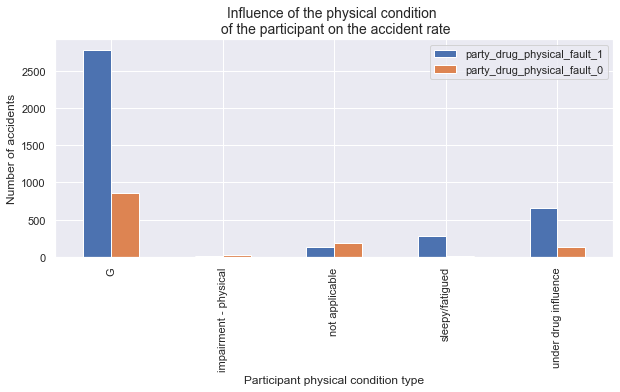

In [68]:
party_drug_physical_fault_1 = data_df_[data_df_['at_fault']==1].pivot_table(index='party_drug_physical', values='at_fault', aggfunc='count')
party_drug_physical_fault_0 = data_df_[data_df_['at_fault']==0].pivot_table(index='party_drug_physical', values='at_fault', aggfunc='count')
party_drug_physical_fault_1.merge(party_drug_physical_fault_0, on='party_drug_physical', how='outer').plot(kind='bar', figsize=(10, 4)).set_title(
    'Influence of the physical condition \n of the participant on the accident rate', fontsize=14)
plt.legend(['party_drug_physical_fault_1', 'party_drug_physical_fault_0'])
plt.xlabel('Participant physical condition type', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

There are more than 90% gaps in this field. It makes no sense to fill in so many gaps. It's easier to remove this column.

**Fill in the gaps in the `lighting` column**

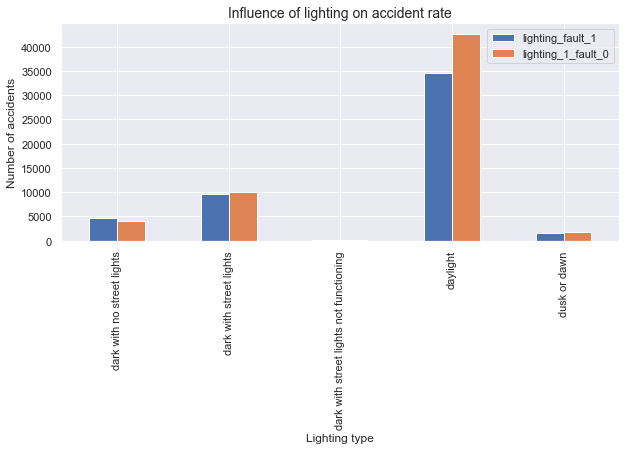

In [69]:
lighting_fault_1 = data_df_[data_df_['at_fault']==1].pivot_table(index='lighting', values='at_fault', aggfunc='count')
lighting_fault_0 = data_df_[data_df_['at_fault']==0].pivot_table(index='lighting', values='at_fault', aggfunc='count')
lighting_fault_1.merge(lighting_fault_0, on='lighting', how='outer').plot(kind='bar', figsize=(10, 4)).set_title(
      'Influence of lighting on accident rate', fontsize=14)
plt.legend(['lighting_fault_1', 'lighting_1_fault_0'])
plt.xlabel('Lighting type', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

In [70]:
# January
data_df_.loc[(data_df_.loc[:,'collision_date'] == 1) &
             
             ((datetime.time(7, 0) <= data_df_.loc[:,'collision_time']) & (data_df_.loc[:,'collision_time'] < datetime.time(17, 0))) &      
             (data_df_.loc[:,'lighting'].isna() == True), 'lighting'] = 'daylight'

data_df_.loc[(data_df_.loc[:,'collision_date'] == 1) &
             
             ((datetime.time(17, 0) <= data_df_.loc[:,'collision_time']) & (data_df_.loc[:,'collision_time'] < datetime.time(7, 0))) &      
             (data_df_.loc[:,'lighting'].isna() == True), 'lighting'] = 'dark with street lights'

# February
data_df_.loc[(data_df_.loc[:,'collision_date'] == 2) &
             
             ((datetime.time(6, 30) <= data_df_.loc[:,'collision_time']) & (data_df_.loc[:,'collision_time'] < datetime.time(17, 30))) &      
             (data_df_.loc[:,'lighting'].isna() == True), 'lighting'] = 'daylight'

data_df_.loc[(data_df_.loc[:,'collision_date'] == 2) &
             
             ((datetime.time(17, 30) <= data_df_.loc[:,'collision_time']) & (data_df_.loc[:,'collision_time'] < datetime.time(6, 30))) &      
             (data_df_.loc[:,'lighting'].isna() == True), 'lighting'] = 'dark with street lights'

# March
data_df_.loc[(data_df_.loc[:,'collision_date'] == 3) &
             
             ((datetime.time(6, 0) <= data_df_.loc[:,'collision_time']) & (data_df_.loc[:,'collision_time'] < datetime.time(18, 0))) &      
             (data_df_.loc[:,'lighting'].isna() == True), 'lighting'] = 'daylight'

data_df_.loc[(data_df_.loc[:,'collision_date'] == 3) &
             
             ((datetime.time(18, 0) <= data_df_.loc[:,'collision_time']) & (data_df_.loc[:,'collision_time'] < datetime.time(6, 0))) &      
             (data_df_.loc[:,'lighting'].isna() == True), 'lighting'] = 'dark with street lights'

# April
data_df_.loc[(data_df_.loc[:,'collision_date'] == 4) &
             
             ((datetime.time(5, 20) <= data_df_.loc[:,'collision_time']) & (data_df_.loc[:,'collision_time'] < datetime.time(18, 20))) &      
             (data_df_.loc[:,'lighting'].isna() == True), 'lighting'] = 'daylight'

data_df_.loc[(data_df_.loc[:,'collision_date'] == 4) &
             
             ((datetime.time(18, 20) <= data_df_.loc[:,'collision_time']) & (data_df_.loc[:,'collision_time'] < datetime.time(5, 20))) &      
             (data_df_.loc[:,'lighting'].isna() == True), 'lighting'] = 'dark with street lights'

# May
data_df_.loc[(data_df_.loc[:,'collision_date'] == 5) &
             
             ((datetime.time(4, 50) <= data_df_.loc[:,'collision_time']) & (data_df_.loc[:,'collision_time'] < datetime.time(18, 45))) &      
             (data_df_.loc[:,'lighting'].isna() == True), 'lighting'] = 'daylight'

data_df_.loc[(data_df_.loc[:,'collision_date'] == 5) &
             
             ((datetime.time(18, 45) <= data_df_.loc[:,'collision_time']) & (data_df_.loc[:,'collision_time'] < datetime.time(4, 50))) &      
             (data_df_.loc[:,'lighting'].isna() == True), 'lighting'] = 'dark with street lights'

# June
data_df_.loc[(data_df_.loc[:,'collision_date'] == 6) &
             
             ((datetime.time(4, 40) <= data_df_.loc[:,'collision_time']) & (data_df_.loc[:,'collision_time'] < datetime.time(19, 0))) &      
             (data_df_.loc[:,'lighting'].isna() == True), 'lighting'] = 'daylight'

data_df_.loc[(data_df_.loc[:,'collision_date'] == 6) &
             
             ((datetime.time(19, 0) <= data_df_.loc[:,'collision_time']) & (data_df_.loc[:,'collision_time'] < datetime.time(4, 40))) &      
             (data_df_.loc[:,'lighting'].isna() == True), 'lighting'] = 'dark with street lights'

# July
data_df_.loc[(data_df_.loc[:,'collision_date'] == 7) &
             
             ((datetime.time(4, 50) <= data_df_.loc[:,'collision_time']) & (data_df_.loc[:,'collision_time'] < datetime.time(19, 0))) &      
             (data_df_.loc[:,'lighting'].isna() == True), 'lighting'] = 'daylight'

data_df_.loc[(data_df_.loc[:,'collision_date'] == 7) &
             
             ((datetime.time(19, 0) <= data_df_.loc[:,'collision_time']) & (data_df_.loc[:,'collision_time'] < datetime.time(4, 50))) &      
             (data_df_.loc[:,'lighting'].isna() == True), 'lighting'] = 'dark with street lights'

# August
data_df_.loc[(data_df_.loc[:,'collision_date'] == 8) &
             
             ((datetime.time(5, 15) <= data_df_.loc[:,'collision_time']) & (data_df_.loc[:,'collision_time'] < datetime.time(18, 30))) &      
             (data_df_.loc[:,'lighting'].isna() == True), 'lighting'] = 'daylight'

data_df_.loc[(data_df_.loc[:,'collision_date'] == 8) &
             
             ((datetime.time(18, 30) <= data_df_.loc[:,'collision_time']) & (data_df_.loc[:,'collision_time'] < datetime.time(5, 15))) &      
             (data_df_.loc[:,'lighting'].isna() == True), 'lighting'] = 'dark with street lights'

# September
data_df_.loc[(data_df_.loc[:,'collision_date'] == 9) &
             
             ((datetime.time(5, 30) <= data_df_.loc[:,'collision_time']) & (data_df_.loc[:,'collision_time'] < datetime.time(18, 0))) &      
             (data_df_.loc[:,'lighting'].isna() == True), 'lighting'] = 'daylight'

data_df_.loc[(data_df_.loc[:,'collision_date'] == 9) &
             
             ((datetime.time(18, 0) <= data_df_.loc[:,'collision_time']) & (data_df_.loc[:,'collision_time'] < datetime.time(5, 30))) &      
             (data_df_.loc[:,'lighting'].isna() == True), 'lighting'] = 'dark with street lights'

# October
data_df_.loc[(data_df_.loc[:,'collision_date'] == 10) &
             
             ((datetime.time(6, 0) <= data_df_.loc[:,'collision_time']) & (data_df_.loc[:,'collision_time'] < datetime.time(17, 20))) &      
             (data_df_.loc[:,'lighting'].isna() == True), 'lighting'] = 'daylight'

data_df_.loc[(data_df_.loc[:,'collision_date'] == 10) &
             
             ((datetime.time(17, 20) <= data_df_.loc[:,'collision_time']) & (data_df_.loc[:,'collision_time'] < datetime.time(6, 0))) &      
             (data_df_.loc[:,'lighting'].isna() == True), 'lighting'] = 'dark with street lights'

# November
data_df_.loc[(data_df_.loc[:,'collision_date'] == 11) &
             
             ((datetime.time(6, 25) <= data_df_.loc[:,'collision_time']) & (data_df_.loc[:,'collision_time'] < datetime.time(16, 50))) &      
             (data_df_.loc[:,'lighting'].isna() == True), 'lighting'] = 'daylight'

data_df_.loc[(data_df_.loc[:,'collision_date'] == 11) &
             
             ((datetime.time(16, 50) <= data_df_.loc[:,'collision_time']) & (data_df_.loc[:,'collision_time'] < datetime.time(6, 25))) &      
             (data_df_.loc[:,'lighting'].isna() == True), 'lighting'] = 'dark with street lights'

# December
data_df_.loc[(data_df_.loc[:,'collision_date'] == 12) &
             
             ((datetime.time(6, 25) <= data_df_.loc[:,'collision_time']) & (data_df_.loc[:,'collision_time'] < datetime.time(16, 50))) &      
             (data_df_.loc[:,'lighting'].isna() == True), 'lighting'] = 'daylight'

data_df_.loc[(data_df_.loc[:,'collision_date'] == 12) &
             
             ((datetime.time(16, 50) <= data_df_.loc[:,'collision_time']) & (data_df_.loc[:,'collision_time'] < datetime.time(6, 25))) &      
             (data_df_.loc[:,'lighting'].isna() == True), 'lighting'] = 'dark with street lights'

In [71]:
data_df_ = data_df_.dropna(subset=['lighting'])
data_df_[data_df_.lighting.isna() == True]

,id_x,case_id,party_number_x,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,id_y,...,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time


**Fill in the blanks in the `direction` field**

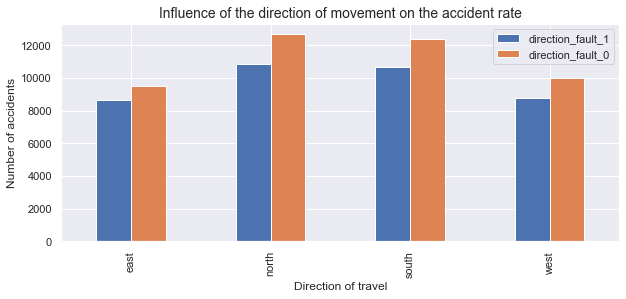

In [72]:
direction_fault_1 = data_df_[data_df_['at_fault']==1].pivot_table(index='direction', values='at_fault', aggfunc='count')
direction_fault_0 = data_df_[data_df_['at_fault']==0].pivot_table(index='direction', values='at_fault', aggfunc='count')
direction_fault_1.merge(direction_fault_0, on='direction', how='outer').plot(kind='bar', figsize=(10, 4)).set_title(
    'Influence of the direction of movement on the accident rate', fontsize=14)
plt.legend(['direction_fault_1', 'direction_fault_0'])
plt.xlabel('Direction of travel', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

The frequency of movement directions is approximately the same, as a result, there is no direction-accident dependence. When passing data to the model, the field can be deleted.

The `intersection` field duplicates the information in the road type (`location_type`) field. Therefore, it can be removed.

**Fill in the blanks in the field type of road (`location_type`)**

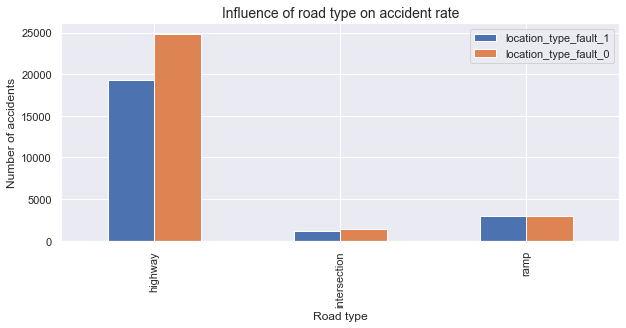

In [73]:
location_type_fault_1 = data_df_[data_df_['at_fault']==1].pivot_table(index='location_type', values='at_fault', aggfunc='count')
location_type_fault_0 = data_df_[data_df_['at_fault']==0].pivot_table(index='location_type', values='at_fault', aggfunc='count')
location_type_fault_1.merge(location_type_fault_0, on='location_type', how='outer').plot(kind='bar', figsize=(10, 4)).set_title(
    'Influence of road type on accident rate', fontsize=14)
plt.legend(['location_type_fault_1', 'location_type_fault_0'])
plt.xlabel('Road type', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

In [74]:
data_df_['location_type'] = data_df_['location_type'].fillna('highway')

**Fill in the blanks in the road type field (`pcf_violation_category`)**

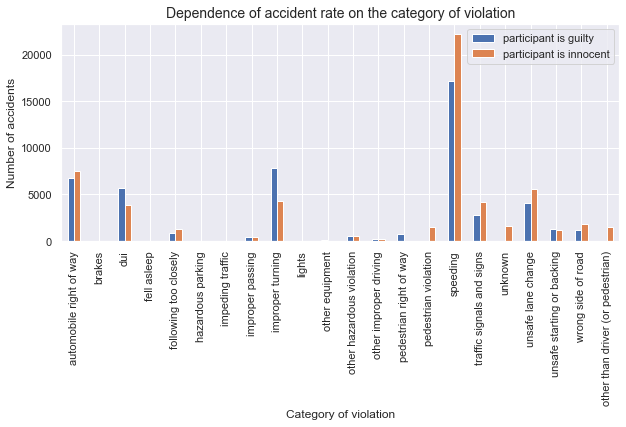

In [75]:
df_1 = data_df_[data_df_['at_fault']==1].pivot_table(index='pcf_violation_category', values='at_fault', aggfunc='count')
df_0 = data_df_[data_df_['at_fault']==0].pivot_table(index='pcf_violation_category', values='at_fault', aggfunc='count')
df_1.merge(df_0, on='pcf_violation_category', how='outer').plot(kind='bar', figsize=(10, 4)).set_title(
    'Dependence of accident rate on the category of violation', fontsize=14)
plt.legend(['participant is guilty', 'participant is innocent'])
plt.xlabel('Category of violation', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

In [76]:
data_df_.corr()

,id_x,case_id,party_number_x,at_fault,insurance_premium,cellphone_in_use,id_y,party_number_y,vehicle_age,distance,intersection,party_count,collision_date
id_x,1.000000,0.998011,-0.002111,0.000533,-0.011260,0.011256,0.999930,-0.009323,-0.000678,0.010405,0.012490,-0.002994,0.788766
case_id,0.998011,1.000000,-0.002561,0.000553,-0.011621,0.010649,0.998288,-0.009609,-0.000904,0.011259,0.012319,-0.003695,0.786774
party_number_x,-0.002111,-0.002561,1.000000,-0.640429,0.073421,-0.000759,-0.002099,0.304300,0.016620,-0.007975,-0.034882,0.554558,0.001334
at_fault,0.000533,0.000553,-0.640429,1.000000,-0.119340,-0.016626,0.000538,-0.146973,-0.010243,0.013710,-0.019435,-0.254408,-0.000730
insurance_premium,-0.011260,-0.011621,0.073421,-0.119340,1.000000,0.000508,-0.011320,0.023416,0.331223,0.004632,0.031167,0.039967,0.007667
cellphone_in_use,0.011256,0.010649,-0.000759,-0.016626,0.000508,1.000000,0.011432,-0.006602,-0.002587,-0.017358,0.101708,-0.007621,-0.001543
id_y,0.999930,0.998288,-0.002099,0.000538,-0.011320,0.011432,1.000000,-0.009262,-0.000595,0.010514,0.012442,-0.002957,0.789932
party_number_y,-0.009323,-0.009609,0.304300,-0.146973,0.023416,-0.006602,-0.009262,1.000000,0.040211,-0.008567,-0.031105,0.536073,-0.010422
vehicle_age,-0.000678,-0.000904,0.016620,-0.010243,0.331223,-0.002587,-0.000595,0.040211,1.000000,0.008823,0.016207,0.030980,0.033394
distance,0.010405,0.011259,-0.007975,0.013710,0.004632,-0.017358,0.010514,-0.008567,0.008823,1.000000,-0.057701,-0.016717,0.018939


The fields id_x, id_y appeared as a result of joining tables. They do not contain useful information. In other fields, no strong linear relationships can be traced. Perhaps the relationship is non-linear.

In [77]:
data_df_['pcf_violation_category'] = data_df_['pcf_violation_category'].fillna('speeding')

**Fill in the gaps in the `primary_collision_factor` field**

In [78]:
data_df_['primary_collision_factor'] = data_df_['primary_collision_factor'].fillna('vehicle code violation')

**Fill in the blanks in the field additional participants in the accident (`motor_vehicle_involved_with`)**

In [79]:
data_df_['motor_vehicle_involved_with'] = data_df_['motor_vehicle_involved_with'].fillna('other motor vehicle')

**Fill in the blanks in the `control_device` field**

In [80]:
data_df_['control_device'] = data_df_['control_device'].fillna('functioning')

**Fill in the gaps in the crash type field (`type_of_collision`)**

In [81]:
data_df_['type_of_collision'] = data_df_['type_of_collision'].fillna('rear end')

Converting numeric fields of type `float` to type `int` to save memory and speed calculations:

In [82]:
data_df_.insurance_premium = data_df_.insurance_premium.map(int)
data_df_.vehicle_age = data_df_.vehicle_age.map(int)
data_df_.distance = data_df_.distance.map(int)

In [83]:
data_df_ = data_df_.drop([
                   'collision_time',
                   'direction',
                   'intersection', 
                   'party_drug_physical', 
                   'id_x',                             
                   'id_y',                                                
                   'case_id', 
                   'party_type', 
                   'party_number_x',
                   'party_number_y',
                   'county_city_location',
                   'county_location'
], axis=1)

In [84]:
data_df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109447 entries, 0 to 113748
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   at_fault                     109447 non-null  int64 
 1   insurance_premium            109447 non-null  int64 
 2   party_sobriety               109447 non-null  object
 3   cellphone_in_use             109447 non-null  int64 
 4   vehicle_type                 109447 non-null  object
 5   vehicle_transmission         109447 non-null  object
 6   vehicle_age                  109447 non-null  int64 
 7   distance                     109447 non-null  int64 
 8   weather_1                    109447 non-null  object
 9   location_type                109447 non-null  object
 10  collision_damage             109447 non-null  object
 11  party_count                  109447 non-null  int64 
 12  primary_collision_factor     109447 non-null  object
 13  pcf_violation_

In [85]:
del df_1
del df_0
del parties_df
del whole_collisions_df
del collisions_df
del vehicles_df

### Data normalization

In [86]:
cat_list = []
num_list = []

for column in data_df_:
    if data_df_[column].dtype == 'object':
        cat_list.append(data_df_[[column]].columns[0])
    else:
        num_list.append(data_df_[[column]].columns[0])

ohe = OneHotEncoder()
        
cat_features = data_df_[cat_list]  #   categorical features
num_features = data_df_[num_list]  #   numerical features

cat_normalized = pd.DataFrame(ohe.fit_transform(cat_features).toarray()) 
cat_normalized.columns = ohe.get_feature_names_out()
data_concat = pd.concat([num_features.reset_index(drop=True), cat_normalized], axis=1)

In [87]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(
    data_concat.drop(['at_fault'], axis=1), 
    data_concat.at_fault, 
    test_size=0.2, 
    shuffle=True,
    random_state=42)

In [88]:
num_list.remove('at_fault')

In [89]:
scaler = StandardScaler()

X_train_num = pd.DataFrame(scaler.fit_transform(X_train_[num_list]))
X_train_num.columns = num_list

X_train_cat = X_train_.drop(num_list, axis=1).reset_index(drop=True)
X_train_ = pd.concat([X_train_num,  X_train_cat], axis=1)

X_test_num = pd.DataFrame(scaler.transform(X_test_[num_list]))
X_test_num.columns = num_list

X_test_cat = X_test_.drop(num_list, axis=1).reset_index(drop=True)
X_test_ = pd.concat([X_test_num,  X_test_cat], axis=1)

In [90]:
X_train_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87557 entries, 0 to 87556
Data columns (total 97 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   insurance_premium                                           87557 non-null  float64
 1   cellphone_in_use                                            87557 non-null  float64
 2   vehicle_age                                                 87557 non-null  float64
 3   distance                                                    87557 non-null  float64
 4   party_count                                                 87557 non-null  float64
 5   collision_date                                              87557 non-null  float64
 6   party_sobriety_had been drinking, impairment unknown        87557 non-null  float64
 7   party_sobriety_had been drinking, not under influence       87557 non-null  float64
 

In [91]:
data_df_[cat_list].nunique()

party_sobriety                  6
vehicle_type                    5
vehicle_transmission            2
weather_1                       7
location_type                   3
collision_damage                4
primary_collision_factor        5
pcf_violation_category         22
type_of_collision               7
motor_vehicle_involved_with     9
road_surface                    4
road_condition_1                8
lighting                        5
control_device                  4
dtype: int64

In [92]:
X_train = torch.FloatTensor(X_train_.values)
X_test = torch.FloatTensor(X_test_.values)
y_train = torch.FloatTensor(y_train_.values)
y_test = torch.FloatTensor(y_test_.values)

In [93]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)  

## Model for driving risk assessment

### Fully connected neural network model

In [131]:
%%time
best_f1_test = 0
best_loss_list = None
best_f1_list_train = None
best_f1_list_test = None
best_n_hidden_neurons_1 = None
best_n_hidden_neurons_2 = None
        
for n_hidden_neurons_1 in [10, 20, 40, 80]:
    for n_hidden_neurons_2 in [2, 4, 8]:
        
        n_in_neurons = 97
        n_out_neurons = 1 

        net = nn.Sequential(
            nn.Linear(n_in_neurons, n_hidden_neurons_1),
            nn.ReLU(),
            nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
            nn.ReLU(),
            nn.Linear(n_hidden_neurons_2, n_out_neurons),
            nn.Sigmoid()
        )

        optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

        loss = nn.BCELoss()

        num_epochs = 1000

        loss_list = []
        f1_list_train = []
        f1_list_test = []

        for epoch in range(num_epochs):
    
            optimizer.zero_grad()

            preds_train = net.forward(X_train).flatten()
    
            loss_value = loss(preds_train , y_train)

            loss_value.backward()
      
            optimizer.step()
    
            loss_list.append(loss_value.detach().numpy()) 
    
            f1_train = f1_score(y_train.numpy(), preds_train.round().detach().numpy())
    
            f1_list_train.append(f1_train)
    
            net.eval()
    
            preds_test = net.forward(X_test).flatten()
    
            f1_test = f1_score(y_test.numpy(), preds_test.round().detach().numpy())
    
            f1_list_test.append(f1_test)
    
        max_f1_test = max(f1_list_test)
        if best_f1_test < max_f1_test:
            best_f1_test = max_f1_test 
            best_loss_list = loss_list
            best_f1_list_train = f1_list_train
            best_f1_list_test = f1_list_test
            best_n_hidden_neurons_1 = n_hidden_neurons_1
            best_n_hidden_neurons_2 = n_hidden_neurons_2
            
for i in range(len(best_f1_list_train)):
    if i % 100 == 0 or i == len(best_f1_list_train) - 1:     
        print(best_f1_list_train[i], best_f1_list_test[i], i)

0.0 0.0 0
0.6561446865872838 0.6487799492105553 100
0.6588934613625972 0.6503330947530694 200
0.6665725140169758 0.6440677966101696 300
0.6816750672270043 0.6351064440236414 400
0.6662570726410242 0.6472723273207216 500
0.6625548364678799 0.6560347568083077 600
0.6758479622287291 0.6475857548612628 700
0.6593329226436679 0.6616930887990882 800
0.718876616528834 0.5869481765834933 900
0.6757820240622788 0.646609936865221 999
Wall time: 12min 3s


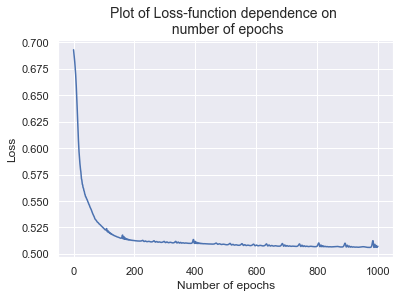

In [95]:
plt.plot(range(num_epochs), best_loss_list )
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title('Plot of Loss-function dependence on \n number of epochs', fontsize=14)
plt.show()

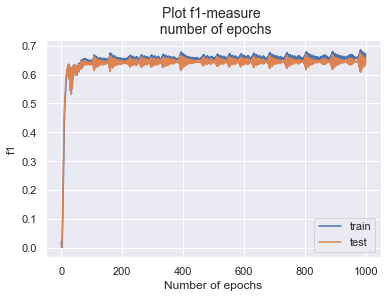

In [96]:
plt.plot(range(num_epochs), best_f1_list_train)
plt.plot(range(num_epochs), best_f1_list_test)
plt.xlabel("Number of epochs")
plt.ylabel("f1")
plt.legend(['train', 'test'])
plt.title('Plot f1-measure \n number of epochs', fontsize=14)
plt.show() 

### Gradient boosting model

#### Catboost HalvingGridSearchCV

In [ ]:
%%time

params = {'iterations': [200, 400, 800],
        'learning_rate': [0.003, 0.03, 0.3],
        'depth': [4, 6, 10]
       }

model = CatBoostClassifier(grow_policy='SymmetricTree',
                           random_state=42,
                           verbose=1,
                           loss_function='Logloss',
                           eval_metric='AUC')

halgridsearch = HalvingGridSearchCV(model,
                                    params,
                                    cv=5,
                                    n_jobs=1,
                                    scoring='roc_auc',
                                    error_score='raise').fit(X_train_, y_train_)
                                                            

In [103]:
halgridsearch.best_params_ 

{'depth': 6, 'iterations': 400, 'learning_rate': 0.03}

In [114]:
model = CatBoostClassifier(grow_policy='SymmetricTree',
                           random_state=42,
                           verbose=False,
                           loss_function='Logloss',
                           depth=6, 
                           iterations=400,
                           learning_rate=0.03).fit(X_train_, y_train_)

roc_auc = np.mean(cross_val_score(model, X_test_, y_test_, cv=5, scoring='roc_auc'))
print('roc_auc:', roc_auc)

roc_auc: 0.7887911135731966


#### CatBoost GridSearch

In [ ]:
%%time

grid = {'iterations': [200, 400, 800],
        'learning_rate': [0.003, 0.03, 0.3],
        'depth': [4, 6, 10],
       }
model = CatBoostClassifier(grow_policy='SymmetricTree',
                           random_state=42,
                           verbose=1,
                           loss_function='Logloss', 
                           eval_metric='AUC')

grid_search_result = model.grid_search(grid,                                    
                                       X=X_train_, 
                                       y=y_train_,
                                       cv=3,
                                       partition_random_seed=1,
                                       calc_cv_statistics=True,
                                       search_by_train_test_split=True,
                                       train_size=0.8,
                                       refit=True,
                                       verbose=False,
                                       plot=True)

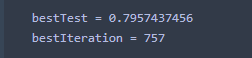

###  RandomForestClassifier (GridSearchCV)

In [105]:
%%time
model_rfc = RandomForestClassifier(random_state=42)

parameters = {'n_estimators': [200, 400, 800],
        'max_depth': [4, 6, 10]
       }
grid = GridSearchCV(model_rfc, 
                    parameters, 
                    cv=3, 
                    scoring='roc_auc', 
                    n_jobs=-1,
                    verbose=1)

grid.fit(X_train_, y_train_)
grid.score(X_test_, y_test_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Wall time: 1min 18s


0.7782557406692929

In [106]:
grid.best_params_

{'max_depth': 10, 'n_estimators': 800}

In [115]:
%%time
model_rfc = RandomForestClassifier(random_state=42)

parameters = {'n_estimators': [250, 350, 375],
        'max_depth': [10]
       }
grid = GridSearchCV(model_rfc, 
                    parameters, 
                    cv=3, 
                    scoring='roc_auc', 
                    n_jobs=-1,
                    verbose=1)

grid.fit(X_train_, y_train_)

grid.best_params_

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Wall time: 30.8 s


{'max_depth': 10, 'n_estimators': 375}

In [116]:
grid.score(X_test_, y_test_)

0.7785623936978248

### Checking the best model on a test set

In [117]:
%%time
ctb = CatBoostClassifier(loss_function='Logloss',
                        iterations=800,
                        random_state=42,
                        learning_rate=0.03,
                        grow_policy='SymmetricTree',
                        verbose=1,
                        depth=10, 
                        eval_metric='AUC')

ctb.fit(X_train_, y_train_)
probabilities_test = ctb.predict_proba(X_test_)
predictions_test_one = probabilities_test[:, 1]
roc_auc_score(y_test_ , predictions_test_one)


0:	total: 25.8ms	remaining: 20.6s
1:	total: 48.2ms	remaining: 19.2s
2:	total: 69.5ms	remaining: 18.5s
3:	total: 90.8ms	remaining: 18.1s
4:	total: 112ms	remaining: 17.9s
5:	total: 134ms	remaining: 17.7s
6:	total: 155ms	remaining: 17.5s
7:	total: 176ms	remaining: 17.4s
8:	total: 198ms	remaining: 17.4s
9:	total: 220ms	remaining: 17.4s
10:	total: 243ms	remaining: 17.4s
11:	total: 265ms	remaining: 17.4s
12:	total: 287ms	remaining: 17.3s
13:	total: 308ms	remaining: 17.3s
14:	total: 330ms	remaining: 17.3s
15:	total: 351ms	remaining: 17.2s
16:	total: 373ms	remaining: 17.2s
17:	total: 395ms	remaining: 17.2s
18:	total: 417ms	remaining: 17.1s
19:	total: 440ms	remaining: 17.1s
20:	total: 462ms	remaining: 17.1s
21:	total: 483ms	remaining: 17.1s
22:	total: 505ms	remaining: 17.1s
23:	total: 528ms	remaining: 17.1s
24:	total: 549ms	remaining: 17s
25:	total: 571ms	remaining: 17s
26:	total: 594ms	remaining: 17s
27:	total: 617ms	remaining: 17s
28:	total: 638ms	remaining: 17s
29:	total: 661ms	remaining: 17

247:	total: 5.52s	remaining: 12.3s
248:	total: 5.54s	remaining: 12.3s
249:	total: 5.57s	remaining: 12.2s
250:	total: 5.59s	remaining: 12.2s
251:	total: 5.61s	remaining: 12.2s
252:	total: 5.63s	remaining: 12.2s
253:	total: 5.66s	remaining: 12.2s
254:	total: 5.68s	remaining: 12.1s
255:	total: 5.7s	remaining: 12.1s
256:	total: 5.72s	remaining: 12.1s
257:	total: 5.75s	remaining: 12.1s
258:	total: 5.77s	remaining: 12.1s
259:	total: 5.79s	remaining: 12s
260:	total: 5.81s	remaining: 12s
261:	total: 5.83s	remaining: 12s
262:	total: 5.86s	remaining: 12s
263:	total: 5.88s	remaining: 11.9s
264:	total: 5.9s	remaining: 11.9s
265:	total: 5.92s	remaining: 11.9s
266:	total: 5.94s	remaining: 11.9s
267:	total: 5.96s	remaining: 11.8s
268:	total: 5.99s	remaining: 11.8s
269:	total: 6.01s	remaining: 11.8s
270:	total: 6.03s	remaining: 11.8s
271:	total: 6.05s	remaining: 11.7s
272:	total: 6.07s	remaining: 11.7s
273:	total: 6.09s	remaining: 11.7s
274:	total: 6.12s	remaining: 11.7s
275:	total: 6.14s	remaining: 1

488:	total: 11s	remaining: 7s
489:	total: 11s	remaining: 6.98s
490:	total: 11.1s	remaining: 6.96s
491:	total: 11.1s	remaining: 6.93s
492:	total: 11.1s	remaining: 6.91s
493:	total: 11.1s	remaining: 6.89s
494:	total: 11.1s	remaining: 6.87s
495:	total: 11.2s	remaining: 6.85s
496:	total: 11.2s	remaining: 6.82s
497:	total: 11.2s	remaining: 6.8s
498:	total: 11.2s	remaining: 6.78s
499:	total: 11.3s	remaining: 6.75s
500:	total: 11.3s	remaining: 6.73s
501:	total: 11.3s	remaining: 6.71s
502:	total: 11.3s	remaining: 6.69s
503:	total: 11.3s	remaining: 6.67s
504:	total: 11.4s	remaining: 6.64s
505:	total: 11.4s	remaining: 6.62s
506:	total: 11.4s	remaining: 6.6s
507:	total: 11.4s	remaining: 6.58s
508:	total: 11.5s	remaining: 6.55s
509:	total: 11.5s	remaining: 6.53s
510:	total: 11.5s	remaining: 6.51s
511:	total: 11.5s	remaining: 6.49s
512:	total: 11.6s	remaining: 6.46s
513:	total: 11.6s	remaining: 6.44s
514:	total: 11.6s	remaining: 6.42s
515:	total: 11.6s	remaining: 6.4s
516:	total: 11.6s	remaining: 6

731:	total: 16.3s	remaining: 1.52s
732:	total: 16.4s	remaining: 1.5s
733:	total: 16.4s	remaining: 1.47s
734:	total: 16.4s	remaining: 1.45s
735:	total: 16.4s	remaining: 1.43s
736:	total: 16.5s	remaining: 1.41s
737:	total: 16.5s	remaining: 1.38s
738:	total: 16.5s	remaining: 1.36s
739:	total: 16.5s	remaining: 1.34s
740:	total: 16.5s	remaining: 1.32s
741:	total: 16.6s	remaining: 1.29s
742:	total: 16.6s	remaining: 1.27s
743:	total: 16.6s	remaining: 1.25s
744:	total: 16.6s	remaining: 1.23s
745:	total: 16.7s	remaining: 1.21s
746:	total: 16.7s	remaining: 1.18s
747:	total: 16.7s	remaining: 1.16s
748:	total: 16.7s	remaining: 1.14s
749:	total: 16.7s	remaining: 1.12s
750:	total: 16.8s	remaining: 1.09s
751:	total: 16.8s	remaining: 1.07s
752:	total: 16.8s	remaining: 1.05s
753:	total: 16.8s	remaining: 1.03s
754:	total: 16.9s	remaining: 1s
755:	total: 16.9s	remaining: 982ms
756:	total: 16.9s	remaining: 960ms
757:	total: 16.9s	remaining: 937ms
758:	total: 16.9s	remaining: 915ms
759:	total: 17s	remainin

0.8005073400586871

**Conclusion:**

After reducing the feature space, the quality metric improved for almost all models (for Catboost HalvingGridSearchCV, it slightly deteriorated). The best model turned out to be CatBoost GridSearch, which on the test gave an ROC AUC of 0.8024.

In [118]:
confusion_matrix = pd.DataFrame(get_confusion_matrix(ctb, Pool(X_test_, y_test_)))
confusion_matrix.columns = ['Positive_real', 'Negative_real']
confusion_matrix = confusion_matrix.rename(index={0: 'Positive_pred', 1: 'Negative_pred'})
confusion_matrix

,Positive_real,Negative_real
Positive_pred,10071.0,1752.0
Negative_pred,4330.0,5737.0


- 10071 cases, the model correctly classified as those responsible for the accident (True Positive)
- 1752 cases the model erroneously classified as guilty of an accident (False Positive)
- 4330 cases the model erroneously classified as innocent in the accident (False Negative)
- 5737 cases, the model correctly classified as innocent in an accident (True Negative)

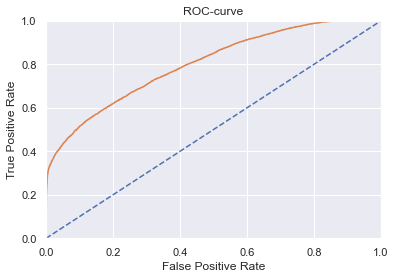

0.8005073400586871

In [119]:
probabilities_test = ctb.predict_proba(X_test_)
predictions_test_one = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_, predictions_test_one)
auc_roc = roc_auc_score(y_test_ , predictions_test_one)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')

plt.show()
display(auc_roc)

The ROC curve shows the ratio between the proportion of objects from the total number of class carriers correctly classified as class carriers and the proportion of objects from the total number of non class carriers incorrectly classified as class carriers. In general, ROC AUC shows the performance of the model and is a good metric for unbalanced classes.

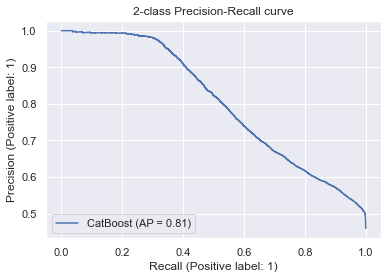

In [120]:
display = PrecisionRecallDisplay.from_estimator(
    ctb, X_test_, y_test_, name="CatBoost"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [121]:
print('Precision:', precision_score(y_test_, ctb.predict(X_test_)))
print('Recall:', recall_score(y_test_, ctb.predict(X_test_)))


Precision: 0.7660568834290292
Recall: 0.5698817919936426


**Precision** - the proportion of objects that are called positive by the classifier and are actually positive.

**Recall* - proportion of positive class objects out of all positive class objects found by the algorithm.

## Analysis of the importance of accident factors

### Analysis of the importance of factors for CatBoost

In [122]:
feature_importances_ctb = ctb.get_feature_importance(prettified=True)
feature_importances_ctb.columns = ['feature_id', 'importance (%)']

In [123]:
feature_importances_ctb.head(20)

,feature_id,importance (%)
0,party_count,21.773813
1,primary_collision_factor_vehicle code violation,11.658924
2,insurance_premium,9.624360
3,party_sobriety_had not been drinking,6.554385
4,pcf_violation_category_dui,6.127210
5,distance,3.407823
6,pcf_violation_category_pedestrian violation,3.122629
7,"party_sobriety_had been drinking, under influence",3.095872
8,collision_date,2.639690
9,vehicle_age,2.478854


### Factor Importance Analysis for RandomForest

In [125]:
model_rfc.fit(X_train_, y_train_)
feature_importances_rf = pd.DataFrame(model_rfc.feature_importances_, X_test_.columns).sort_values(
    0, ascending=False).apply(lambda x: x*100).reset_index()
feature_importances_rf.columns = ['feature_id', 'importance (%)']

In [126]:
feature_importances_rf.head(20)

,feature_id,importance (%)
0,insurance_premium,26.732613
1,distance,11.495167
2,vehicle_age,9.106537
3,collision_date,7.193377
4,party_count,6.606345
5,party_sobriety_had not been drinking,3.019190
6,"party_sobriety_had been drinking, under influence",2.159897
7,pcf_violation_category_dui,1.645543
8,motor_vehicle_involved_with_fixed object,1.214744
9,motor_vehicle_involved_with_other motor vehicle,1.206584


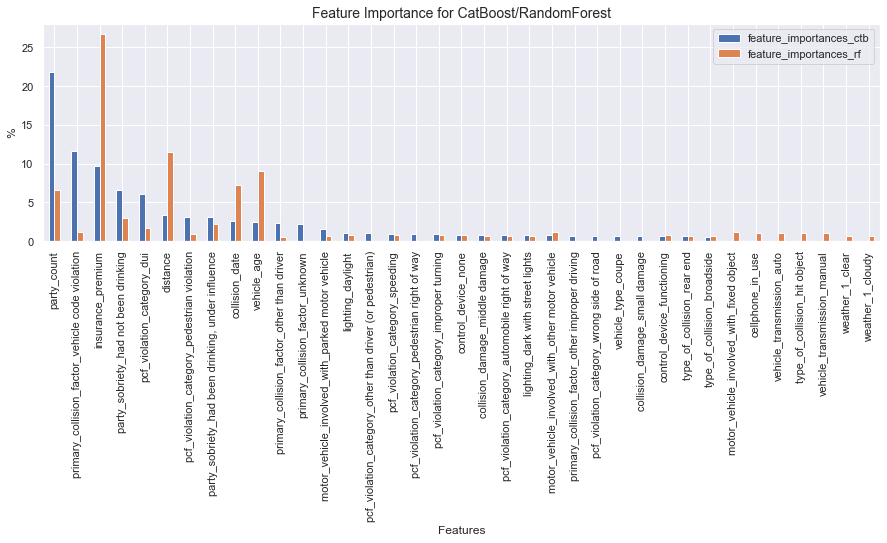

In [127]:
features_importances = feature_importances_ctb.head(30).merge(
    feature_importances_rf.head(30), on='feature_id', how='outer')

features_importances.plot(x='feature_id', kind='bar', figsize=(15, 4)).set_title(
    'Feature Importance for CatBoost/RandomForest', fontsize=14)
plt.legend(['feature_importances_ctb', 'feature_importances_rf'])
plt.xlabel('Features', fontsize=12)
plt.ylabel('%', fontsize=12);

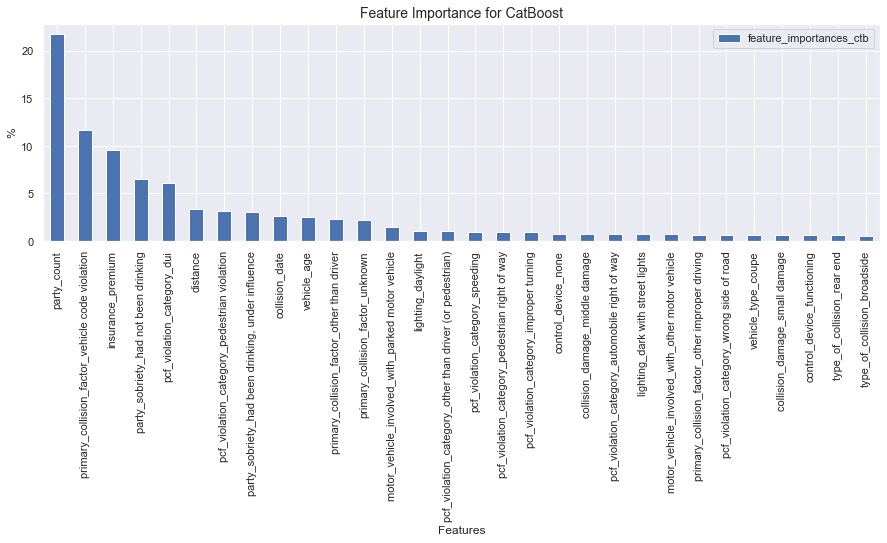

In [128]:
feature_importances_ctb.head(30).plot(x='feature_id', kind='bar', figsize=(15, 4)).set_title(
    'Feature Importance for CatBoost', fontsize=14)
plt.legend(['feature_importances_ctb', 'feature_importances_rf'])
plt.xlabel('Features', fontsize=12)
plt.ylabel('%', fontsize=12);

- The factor "the number of participants in the accident" (`party_count`) is the leader on the scale of importance for this model. However, the number of participants in the accident cannot be predicted in advance.
- In second place is the "primary_collision_factor", which is also difficult to predict, but possible. This factor has the category "violation of traffic rules" as a leader. This factor can be taken into account by the driver's rating and driving experience.
- In third place is "insurance amount" (`insurance_premium`). You can also oblige the client to enter this information into the system.
- In fourth place is the degree of "sobriety of the driver" (`party_sobriety`). As already mentioned in the example task, you can equip the car with a camera and an alcohol intoxication analyzer.
- Then comes the "violation category" (`pcf_violation_category`). Here you can also track violations of a particular driver based on rating and driving experience.


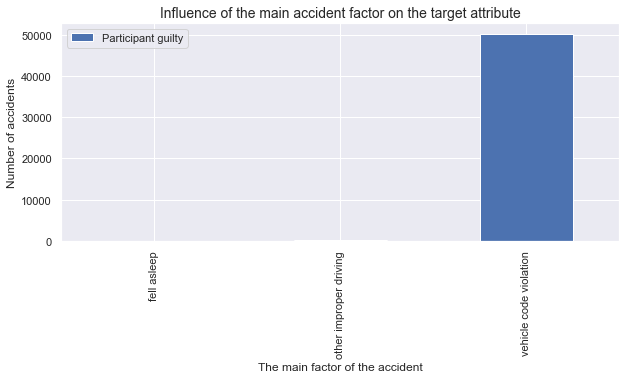

In [129]:
df_1 = data_df_[data_df_['at_fault']==1].pivot_table(index='primary_collision_factor', values='at_fault', aggfunc='count')
df_1.plot(kind='bar', figsize=(10, 4)).set_title('Influence of the main accident factor on the target attribute', fontsize=14)
plt.legend(['Participant guilty'])
plt.xlabel('The main factor of the accident', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

The leader among the main factor of the accident is the category "violation of traffic rules"

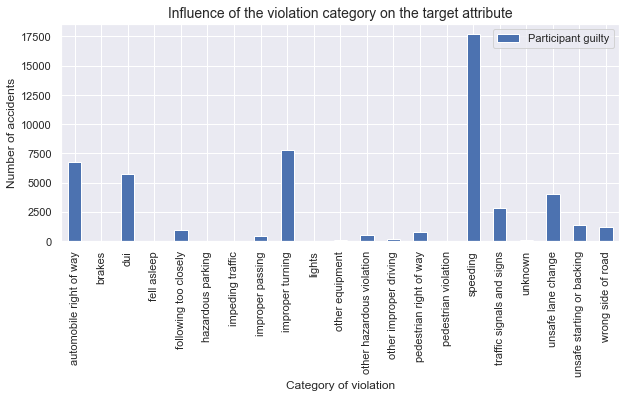

In [130]:
df_1 = data_df_[data_df_['at_fault']==1].pivot_table(index='pcf_violation_category', values='at_fault', aggfunc='count')
df_1.plot(kind='bar', figsize=(10, 4)).set_title('Influence of the violation category on the target attribute', fontsize=14)
plt.legend(['Participant guilty'])
plt.xlabel('Category of violation', fontsize=12)
plt.ylabel('Number of accidents', fontsize=12);

Among the categories of violations, the most are speeding violations.

## Conclusions

During the study, work was done to find the best model for predicting accidents due to the fault of the client. The model on Catboost on GridSearch proved to be the best. During the selection of model hyperparameters, cross-validation was used, which made it possible to most realistically assess the value of the quality metric. ROC AUC was chosen as the quality metric.
ROC AUC = 0.802, which means that with a probability of 80%, the model correctly separates the classes. The metric has proven itself well in binary classification problems, as well as in problems with unbalanced classes.
            
It is quite realistic to create a model predicting the probability of an accident. It is necessary to take into account all the key features that can affect the model. You can create a personal client profile in the application, where he will enter, for example, information about his car insurance, driving experience. It is very important to take into account the client's history of traffic violations. You can try asking the police for information. It is also necessary to take into account the history of the client's accidents in the carsharing company itself, its rating. You can install an analyzer with a camera in the salon to record the physical condition of the client.

You can improve model predictions by adding a field with the number and type of violations from the client earlier. You can also add a driving experience field.